## BAX-422 Machine Learning Final Project
#### Group 12:
- Anurag Vedagiri
- Kuan-Yu (Leo) Liao
- Rishikesan (Rishi) Ravichandran

In this project, we are aiming to build a model that can predict salary for MLB players, using their performance in the games.
We downloaded our files from the Lahman Baseball Database (http://seanlahman.com/)

files to use:
- people: stores all the basic information of all the players ever played in the MLB, we are mainly interested in:
    - age
    - debut date (so we know roughly how many years has he been in the league)
    - left or right handed
    - height / weight
- salaries: stores salary for each player each season, up to 2016
- AwardsPlayers: award winner each year
- Batting: batting stats for each player
- Fielding: fielding stats for each player
- Pitching: pitching stats for each player
- Teams: Tells basic information for each team, including attendence each year.

We are aiming for 5 years of data to do train / test. Since salaries are updated until 2016, we use data from 2012 - 2016.

### Data Merging

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# import data
from pathlib import Path
path = Path("data")
people = pd.read_csv(path / "people.csv")
salaries = pd.read_csv(path / "salaries.csv")
awards = pd.read_csv(path / "AwardsPlayers.csv")
batting = pd.read_csv(path / "batting.csv")
fielding = pd.read_csv(path / "fielding.csv")
pitching = pd.read_csv(path / "pitching.csv")
teams = pd.read_csv(path / "teams.csv")

In [100]:
# only keep necessary columns
people = people[['playerID', 'birthYear', 'birthCountry', 'nameFirst',
                 'nameLast', 'nameGiven','weight','height','bats','throws','debut']]
awards = awards[['playerID', 'awardID', 'yearID']]
teams = teams[['yearID','teamID','attendance']]

# remove unnecessary columns
batting = batting.drop(columns=['teamID','stint','lgID'])
fielding = fielding.drop(columns=['teamID','stint','lgID','POS'])
pitching = pitching.drop(columns=['teamID','stint','lgID'])

In [101]:
# filter data and keep only 2012-2016
years = ['2012', '2013', '2014', '2015', '2016']

salaries = salaries[salaries['yearID'].isin(years)]
awards = awards[awards['yearID'].isin(years)]
batting = batting[batting['yearID'].isin(years)]
fielding = fielding[fielding['yearID'].isin(years)]
pitching = pitching[pitching['yearID'].isin(years)]
teams = teams[teams['yearID'].isin(years)]

In [102]:
# use one-hot encoding to create a column for each award
awards = pd.get_dummies(awards, columns=['awardID'], prefix='award')

# use group by to create just one row for one player every year
awards = awards.groupby(['playerID', 'yearID']).sum().reset_index()

In [103]:
# calculate stats for one player in one year, since some players play multiple positions and for multiple teams
#for batting
batting = batting.groupby(['playerID', 'yearID']).agg({
    'G': 'sum', 'AB': 'sum', 'R': 'sum', 'H': 'sum', '2B': 'sum', '3B': 'sum', 'HR': 'sum',
    'RBI': 'sum', 'SB': 'sum', 'CS': 'sum', 'BB': 'sum', 'SO': 'sum', 'IBB': 'sum', 'SH': 'sum',
    'SF': 'sum', 'GIDP': 'sum'
}).reset_index()

# for fielding
fielding = fielding.groupby(['playerID', 'yearID']).agg({
    'G': 'sum', 'GS': 'sum', 'InnOuts': 'sum', 'PO': 'sum', 'A': 'sum', 'E': 'sum', 'DP': 'sum',
    'PB': 'sum', 'WP': 'sum', 'SB': 'sum', 'CS': 'sum', 'ZR': 'sum'
}).reset_index()

In [104]:
# for pitching: more complicated because ERA can't simply be added together

# define a function to calculate ERA
def era_function(x):
    return x['ER']/(x['IPouts']/27)

# use groupby to sum or average the other stats
pitching = pitching.groupby(['playerID', 'yearID']).agg({
    'W': 'sum', 'L': 'sum', 'G': 'sum', 'GS': 'sum', 'CG':'sum', 'SHO':'sum', 'SV':'sum', 'IPouts':'sum', 
    'H': 'sum', 'ER': 'sum', 'HR': 'sum', 'BB': 'sum', 'SO': 'sum', 'BAOpp':'mean', # use mean here for simplicity
    'IBB': 'sum', 'WP': 'sum', 'HBP': 'sum', 'BK': 'sum', 'BFP': 'sum', 'GF': 'sum', 'R':'sum', 'SH':'sum',
    'SF':'sum', 'GIDP':'sum'
}).reset_index()

# calculate ERA and add to the data
era = pitching.groupby(['playerID', 'yearID'], group_keys=False).apply(era_function).reset_index(name='ERA')
pitching = pd.concat([pitching, era], axis=1).drop(columns=['index'])

In [105]:
# merge dataframes and create one dataset
with_b = pd.merge(people, batting, on = ['playerID'])
with_b_f = pd.merge(with_b, fielding, how = 'outer', on = ['playerID', 'yearID'])
with_b_f_p = pd.merge(with_b_f, pitching, how = 'outer', on = ['playerID', 'yearID'])
with_award = pd.merge(with_b_f_p, awards, how = 'left', on = ['playerID', 'yearID'])
with_salary = pd.merge(with_award, salaries, how = 'left', on = ['playerID', 'yearID'])
final_df = pd.merge(with_salary, teams, how = 'left', on = ['teamID', 'yearID'])

In [106]:
# drop rows without salary data
final_df = final_df.dropna(subset=['salary']).reset_index()

In [107]:
final_df.head()

,index,playerID,birthYear,birthCountry,nameFirst,nameLast,nameGiven,weight,height,bats,...,award_TSN All-Star,award_TSN Major League Player of the Year,award_TSN Pitcher of the Year,award_TSN Reliever of the Year,award_Triple Crown,award_World Series MVP,teamID,lgID,salary,attendance
0,0,aardsda01,1981.0,USA,David,Aardsma,David Allan,215.0,75.0,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NYA,AL,500000.0,3542406.0
1,3,abadfe01,1985.0,D.R.,Fernando,Abad,Fernando Antonio,235.0,74.0,L,...,NaN,NaN,NaN,NaN,NaN,NaN,HOU,NL,485000.0,1607733.0
2,5,abadfe01,1985.0,D.R.,Fernando,Abad,Fernando Antonio,235.0,74.0,L,...,NaN,NaN,NaN,NaN,NaN,NaN,OAK,AL,525900.0,2003628.0
3,6,abadfe01,1985.0,D.R.,Fernando,Abad,Fernando Antonio,235.0,74.0,L,...,NaN,NaN,NaN,NaN,NaN,NaN,OAK,AL,1087500.0,1768175.0
4,7,abadfe01,1985.0,D.R.,Fernando,Abad,Fernando Antonio,235.0,74.0,L,...,NaN,NaN,NaN,NaN,NaN,NaN,MIN,AL,1250000.0,1963912.0


Next, we can add some additional columns such as:
- age  (yearID - birthyear)
- years in the MLB (yearID - debut year)
- whether pitched over 9 innings within a season (too see whether if this player is actually a pitcher)

In [108]:
# write functions to calculate age, years in the league, and pitched over 9 innings
def age(x):
    return x['yearID'] - x['birthYear']

def years(y):
    return y['yearID'] - pd.to_datetime(y['debut']).dt.year

def pitched(x):
    return (x > 27).astype(int)

final_df['pitched_more_than_9_innings'] = pitched(final_df['G'])

In [109]:
# add the columns in the dataframe
age = age(final_df).reset_index(name='age')
yil = years(final_df).reset_index(name='years_in_league')

final_df = pd.concat([final_df, age], axis=1).drop(columns=['index'])
final_df = pd.concat([final_df, yil], axis=1).drop(columns=['index'])

In [110]:
# remove unnecessary columns: birthCountry, playerID, birthYear, debut, nameFirst, nameLast, nameGiven
final_df = final_df.drop(columns=['yearID','birthCountry', 'playerID', 'birthYear', 'debut', 'nameFirst', 'nameLast', 'nameGiven'])

### EDA

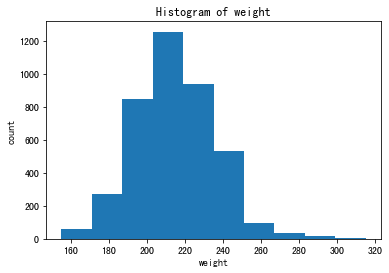

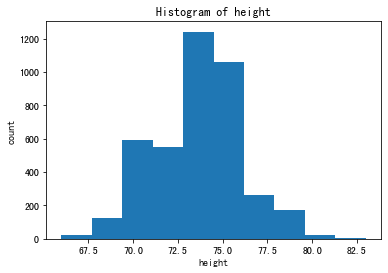

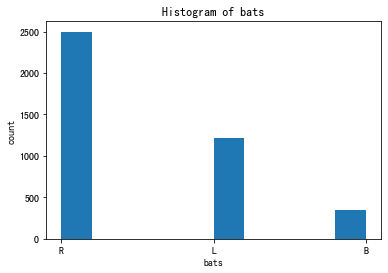

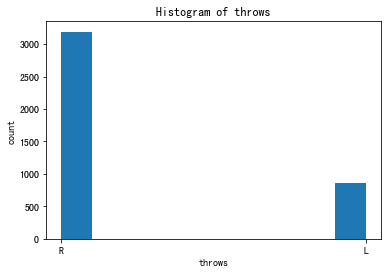

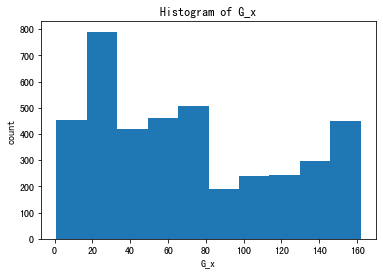

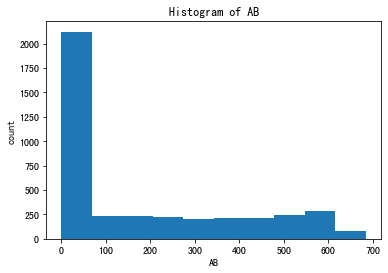

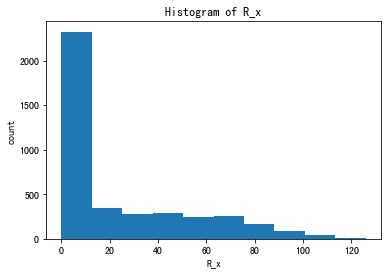

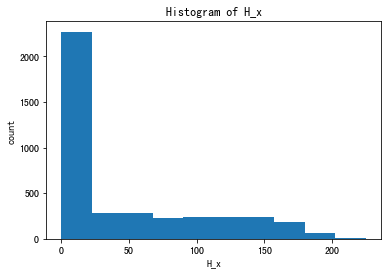

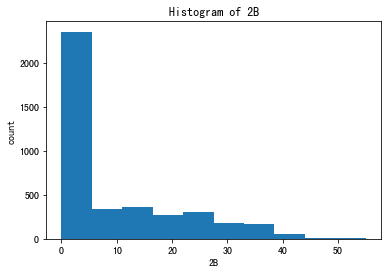

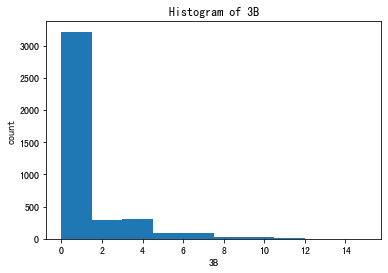

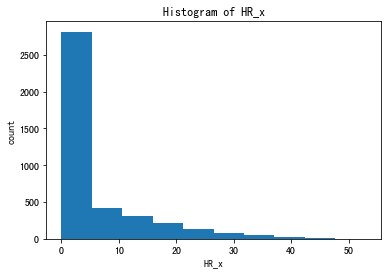

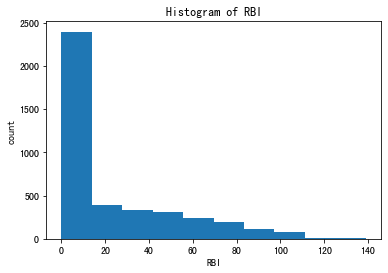

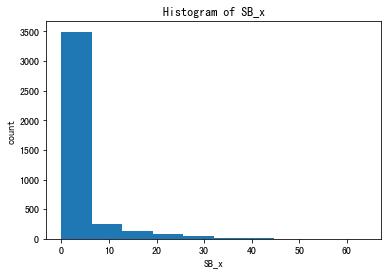

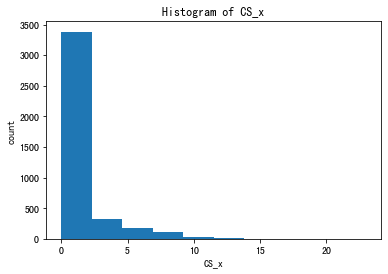

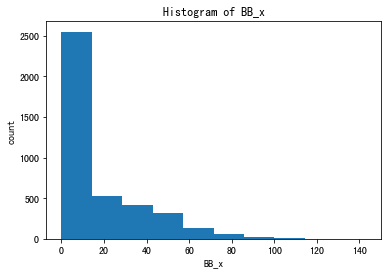

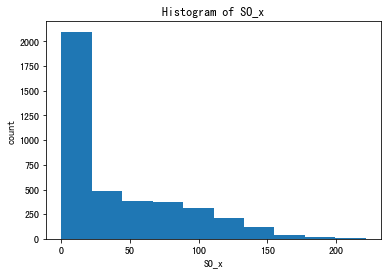

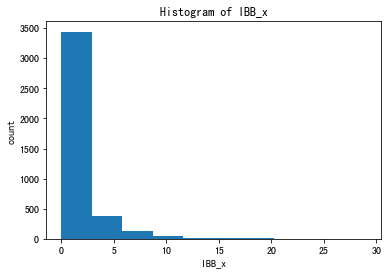

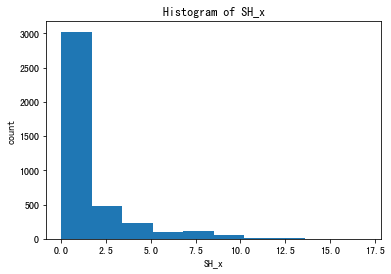

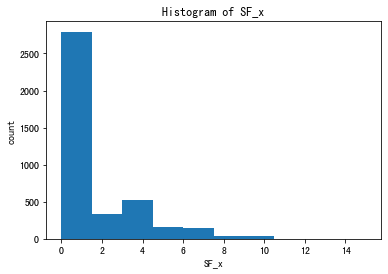

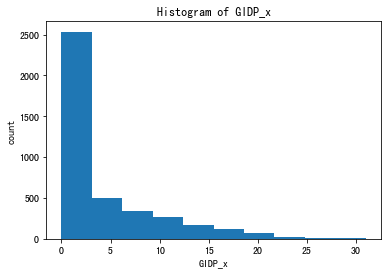

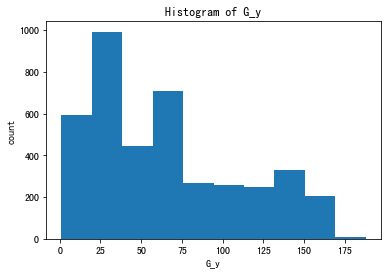

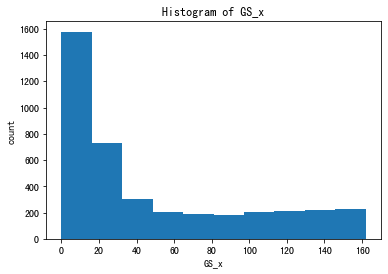

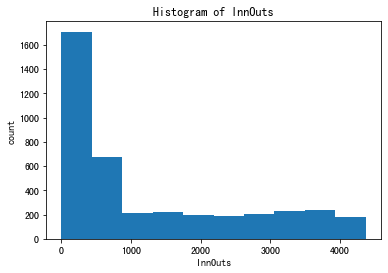

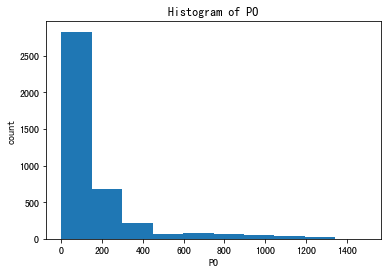

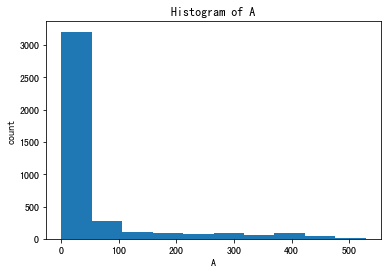

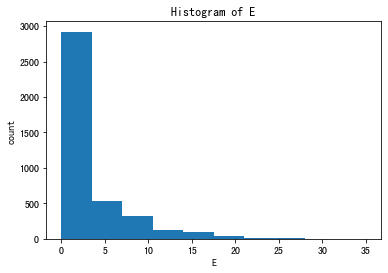

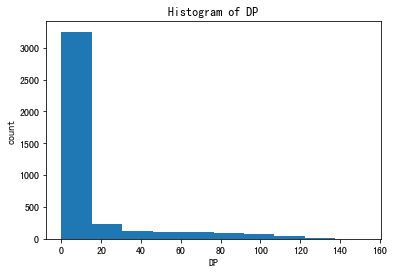

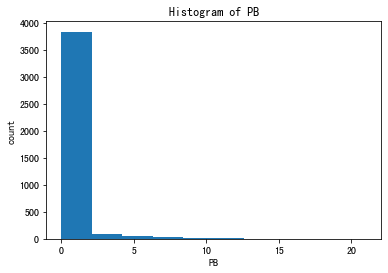

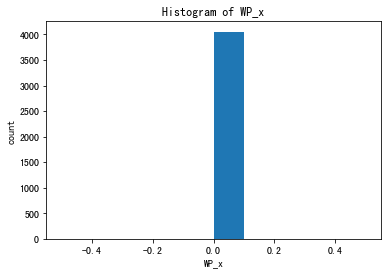

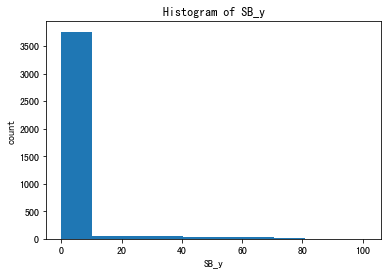

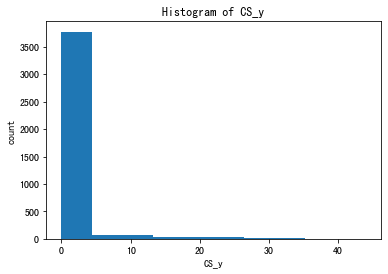

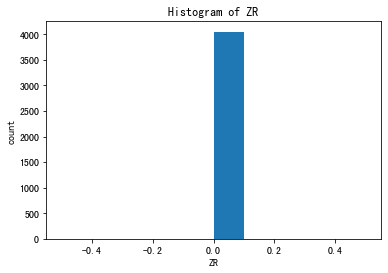

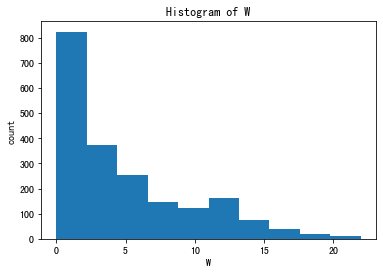

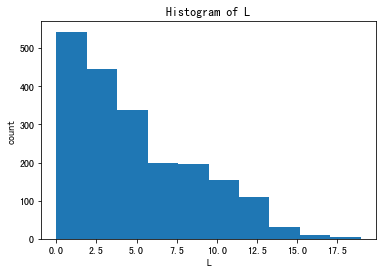

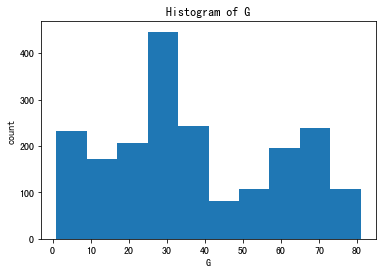

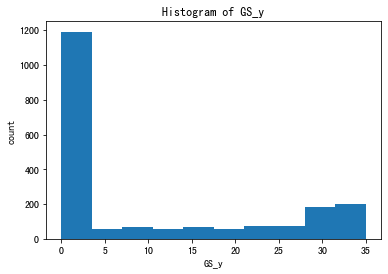

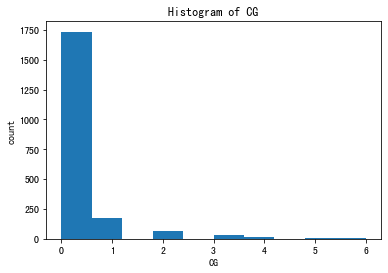

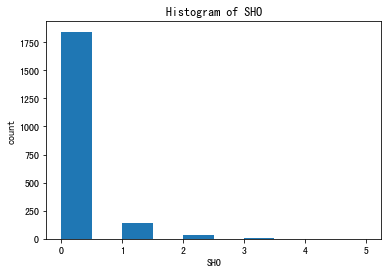

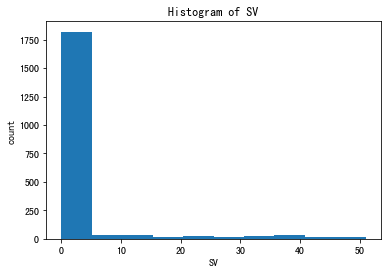

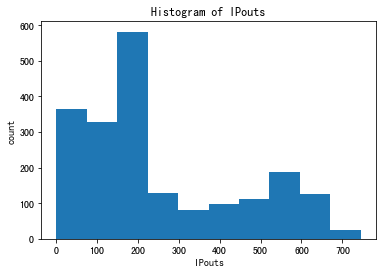

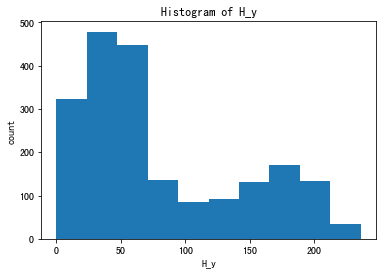

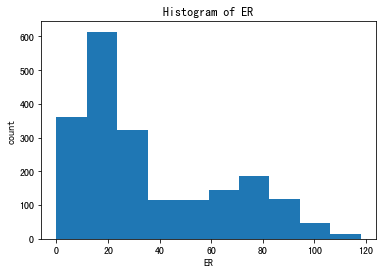

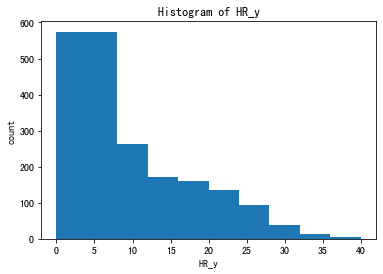

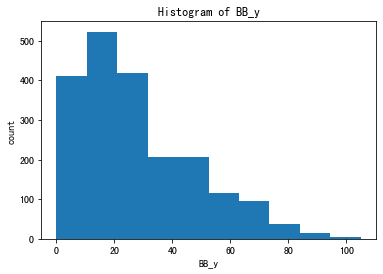

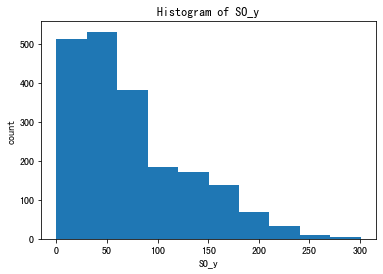

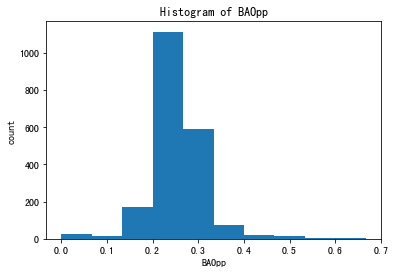

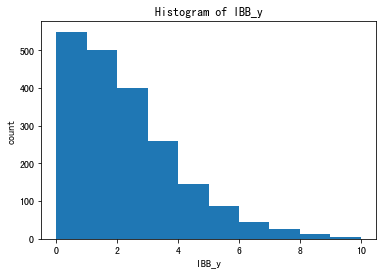

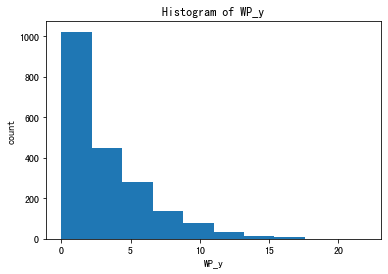

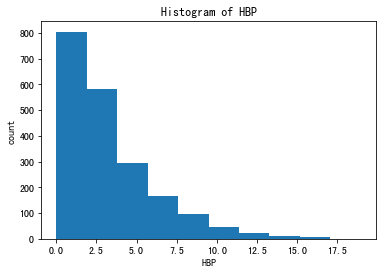

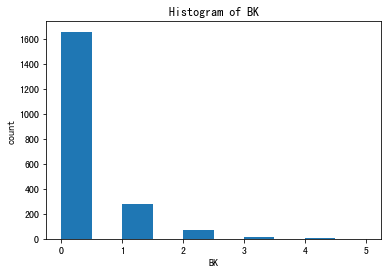

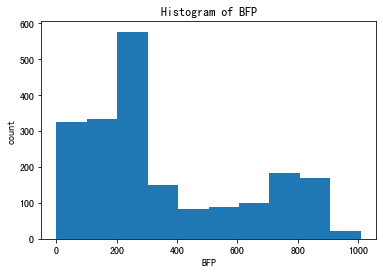

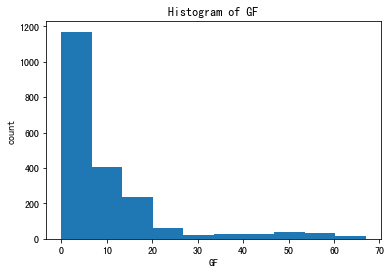

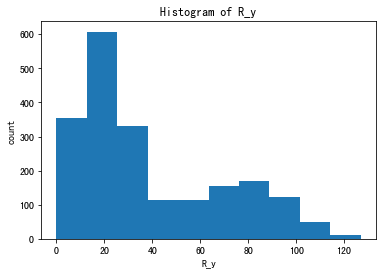

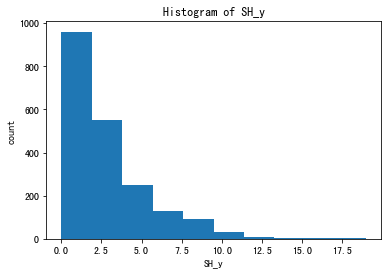

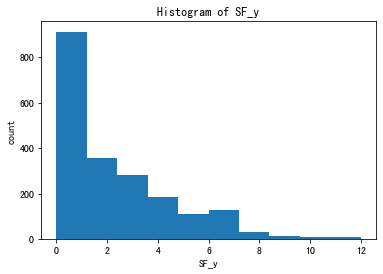

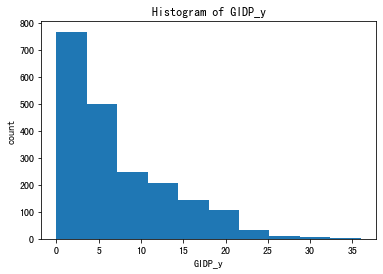

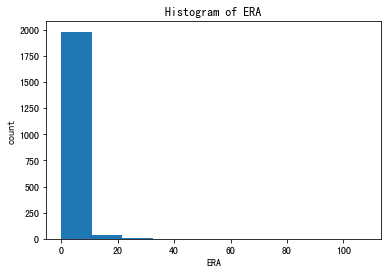

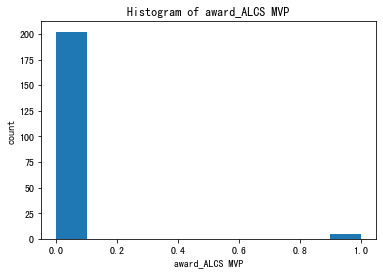

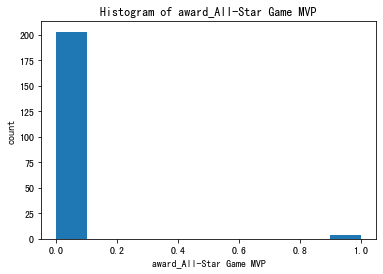

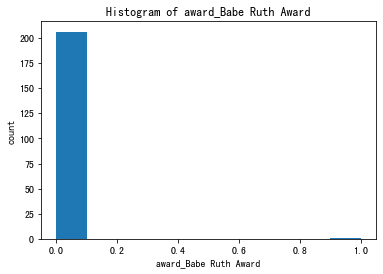

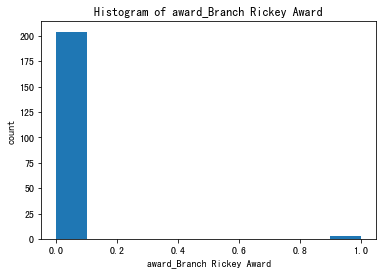

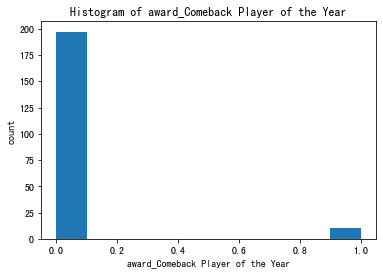

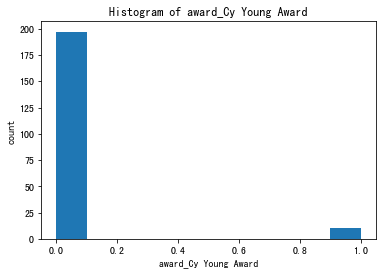

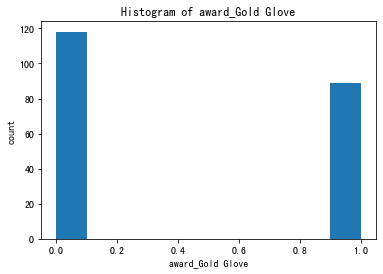

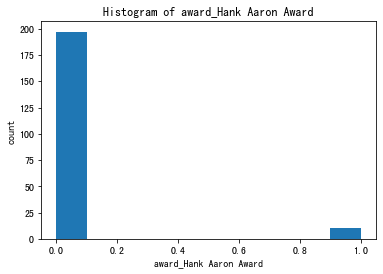

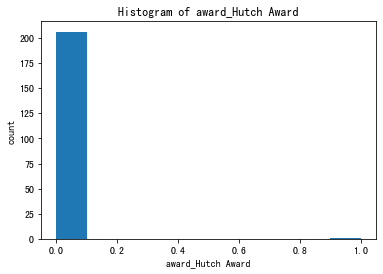

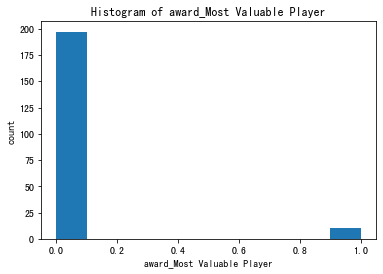

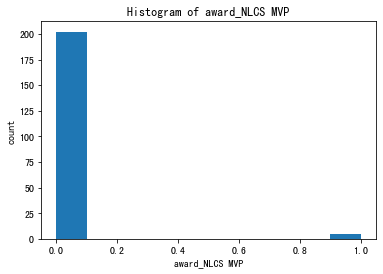

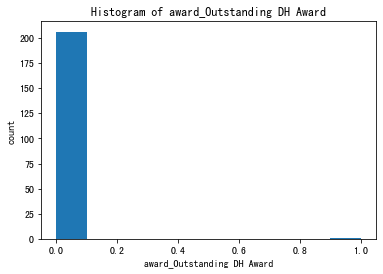

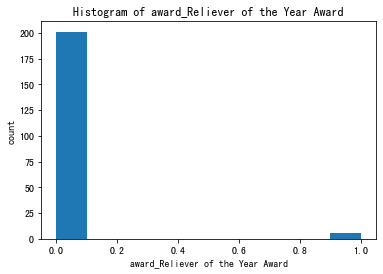

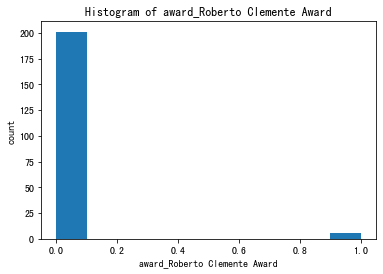

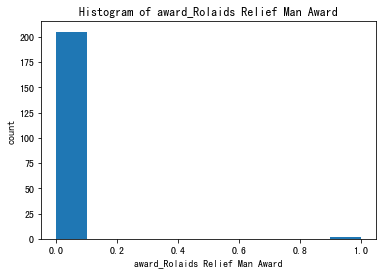

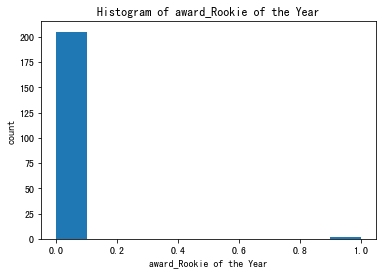

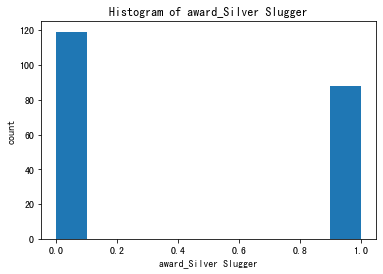

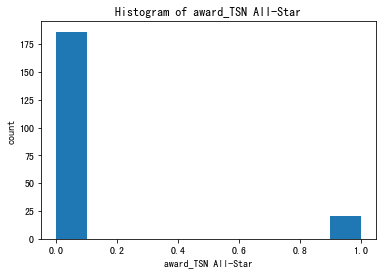

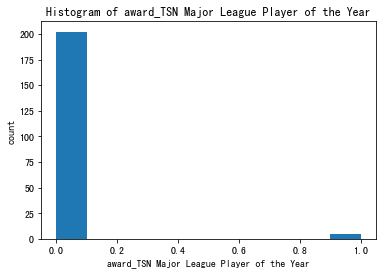

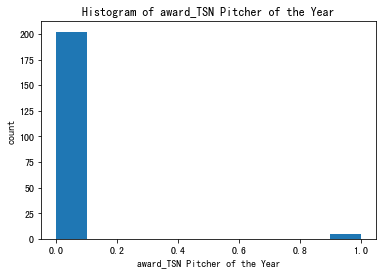

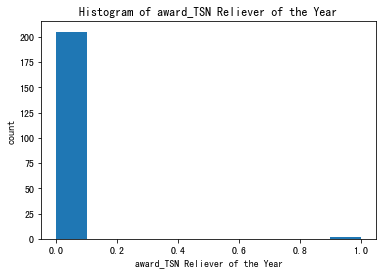

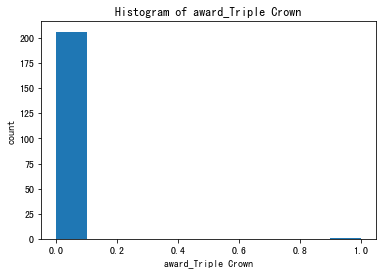

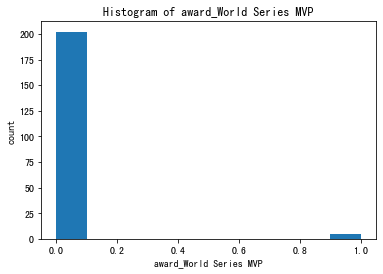

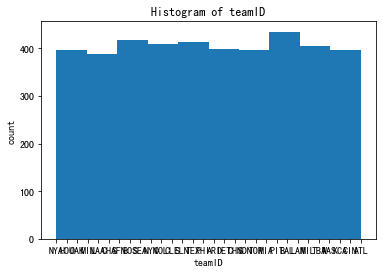

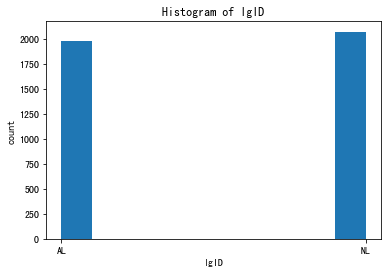

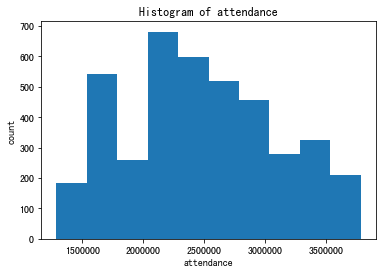

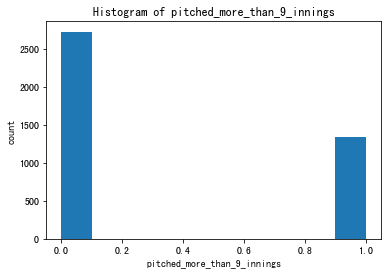

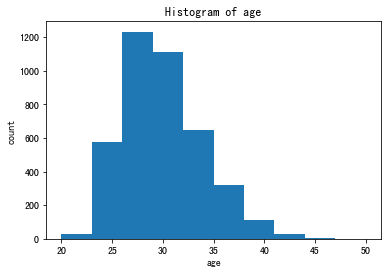

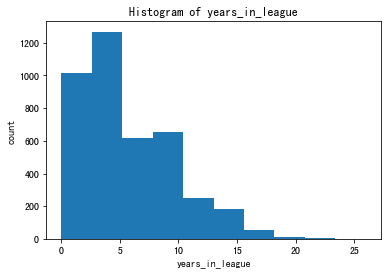

In [111]:
# set x columns as every column other than our dependent variable(salary)
x_columns = final_df.drop(['salary'], axis=1).columns.tolist()

# plot histograms
for x_var in x_columns:
    plt.hist(final_df[x_var])
    plt.title(f'Histogram of {x_var}')
    plt.xlabel(x_var)
    plt.ylabel('count')
    plt.show()

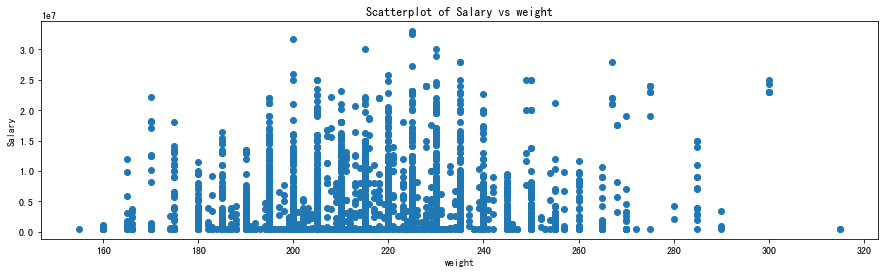

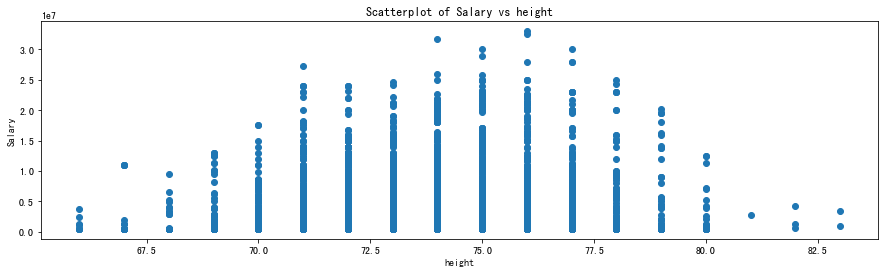

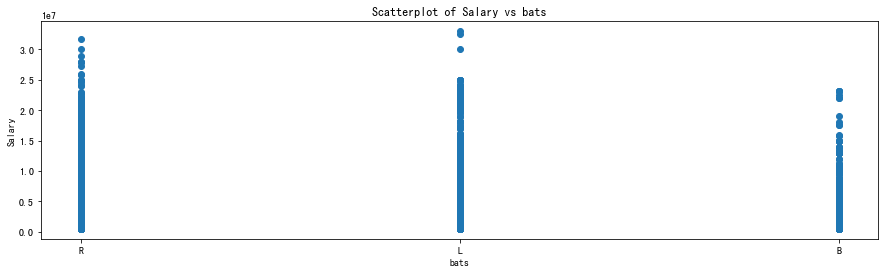

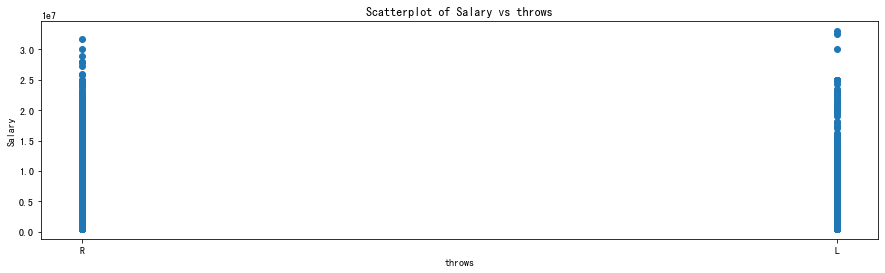

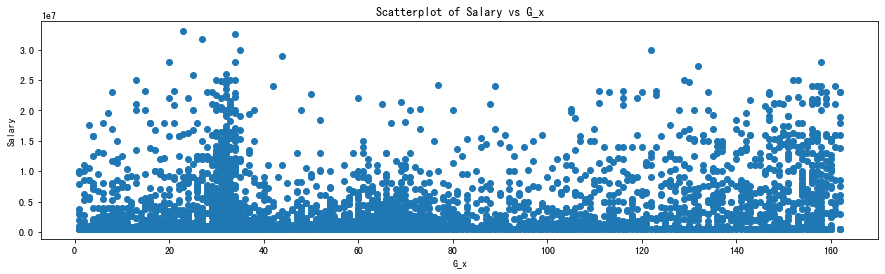

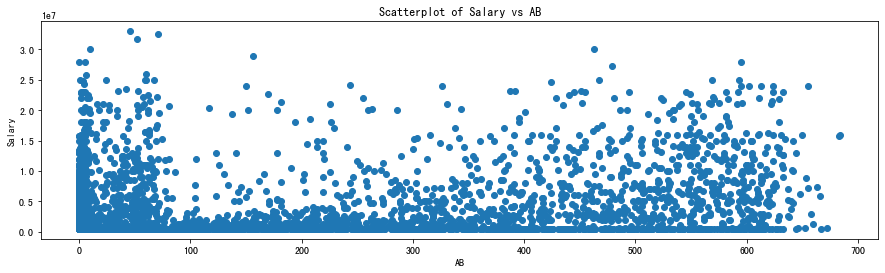

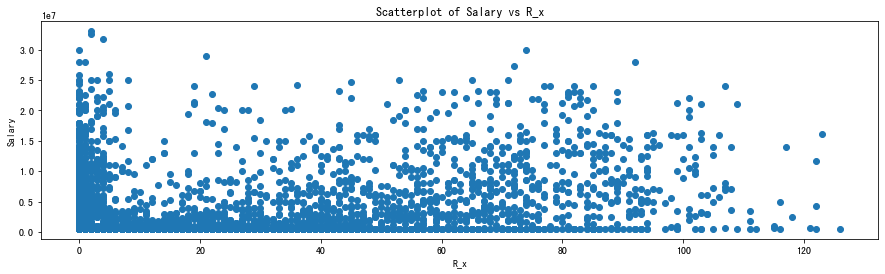

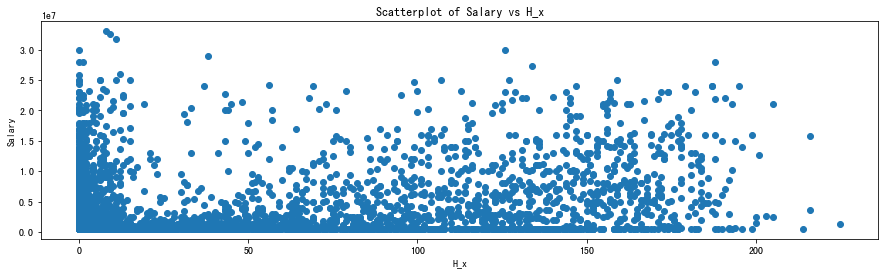

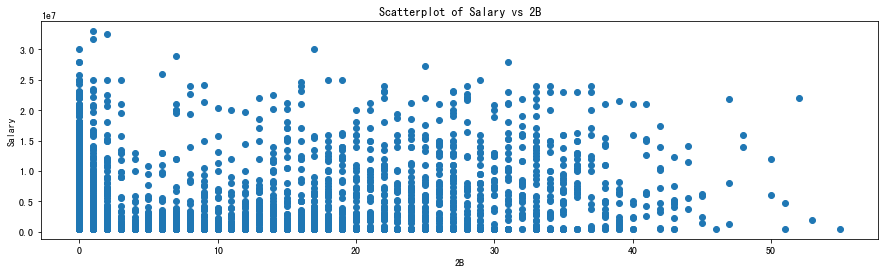

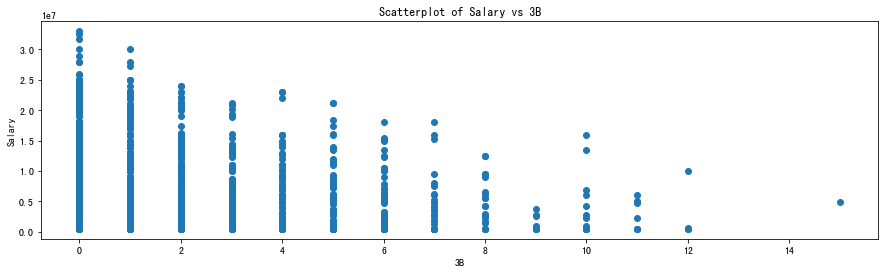

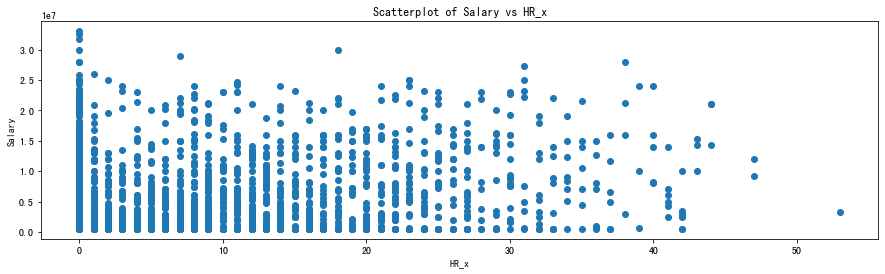

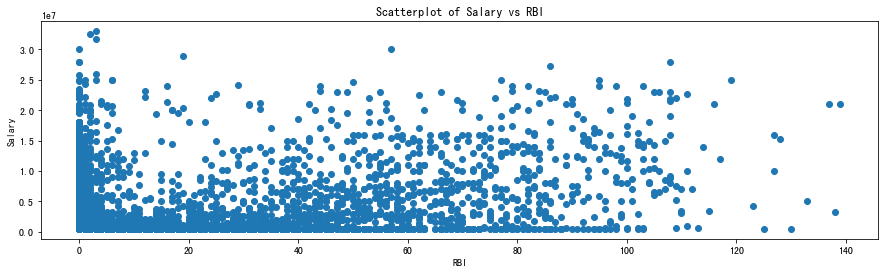

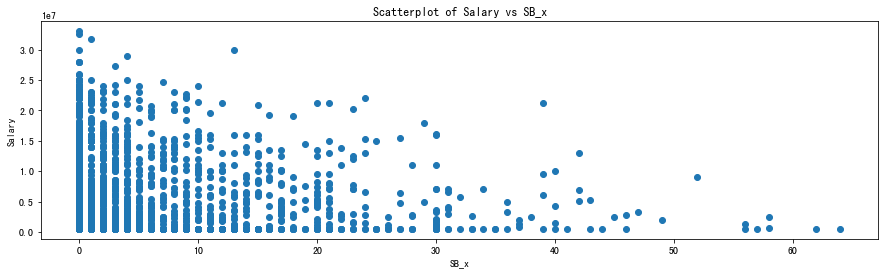

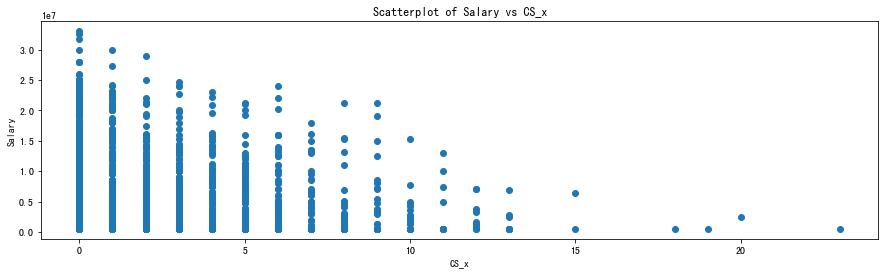

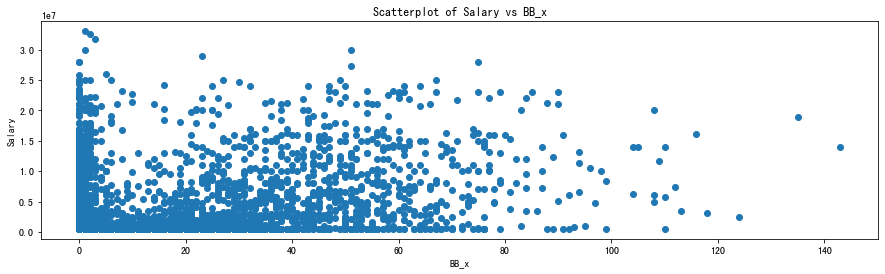

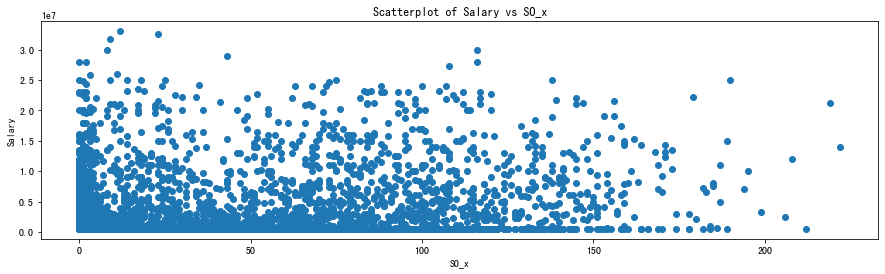

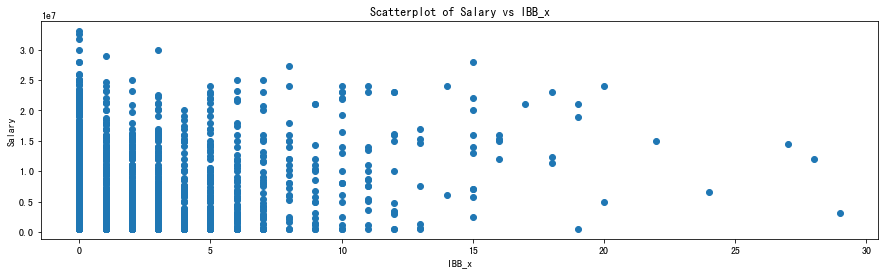

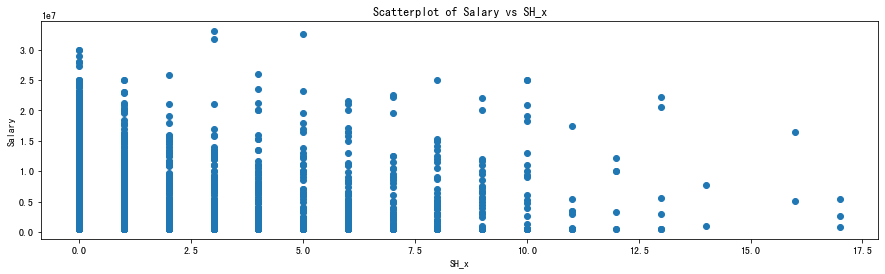

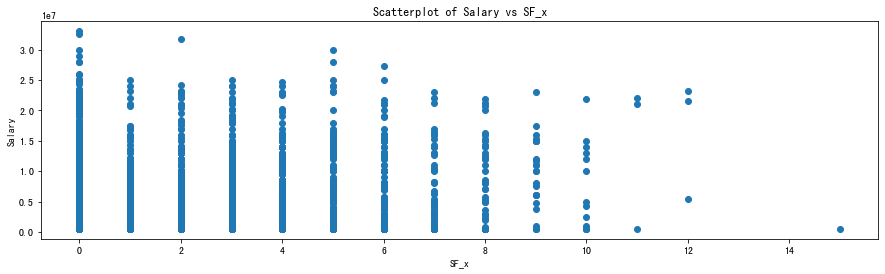

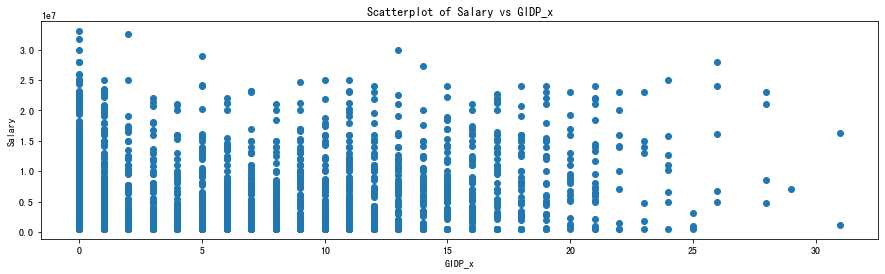

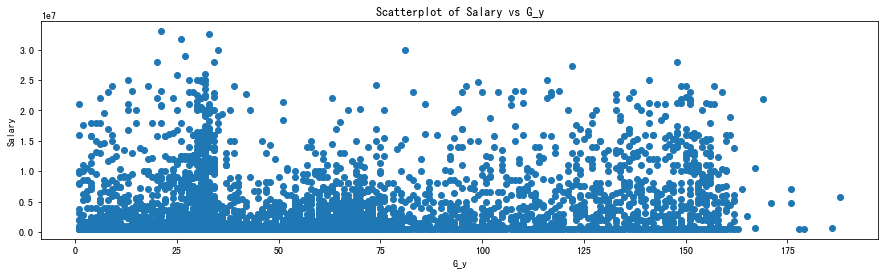

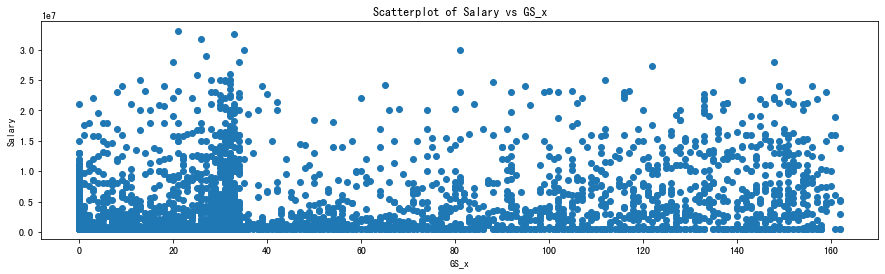

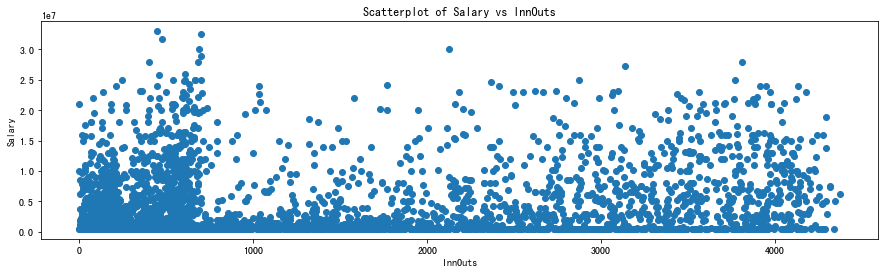

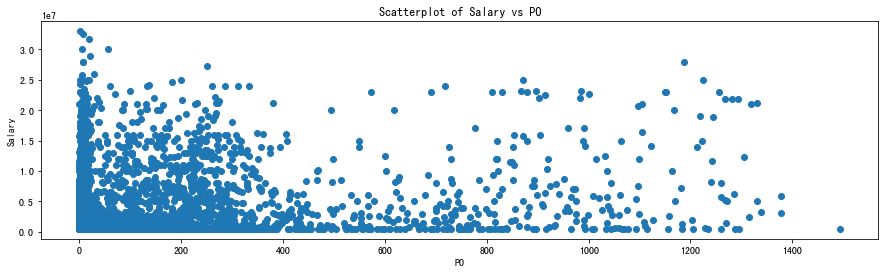

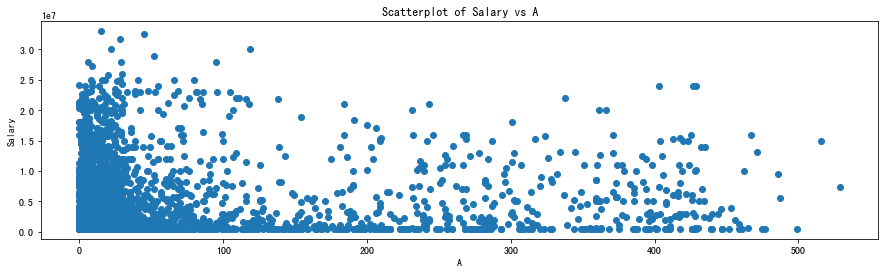

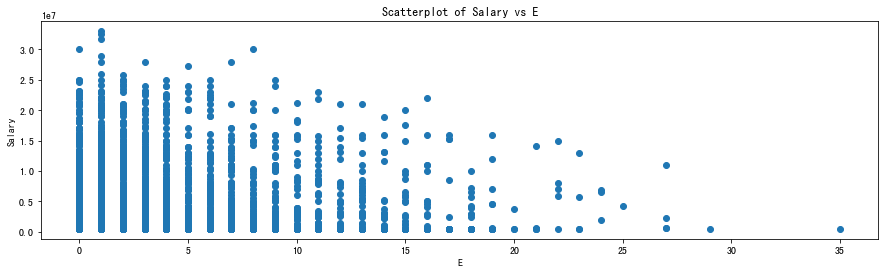

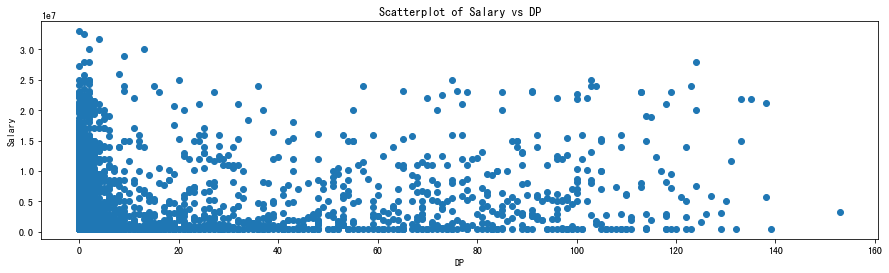

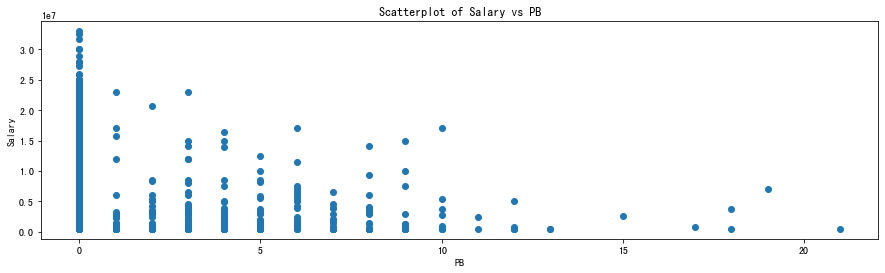

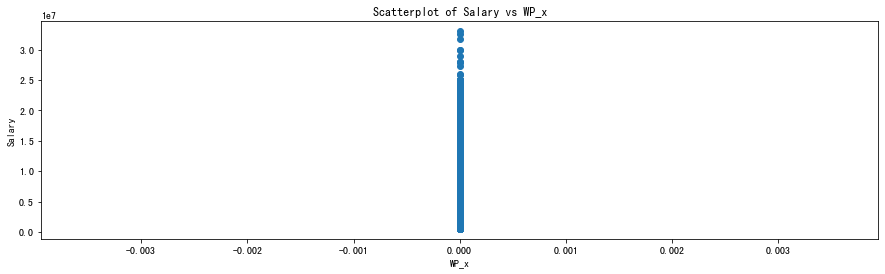

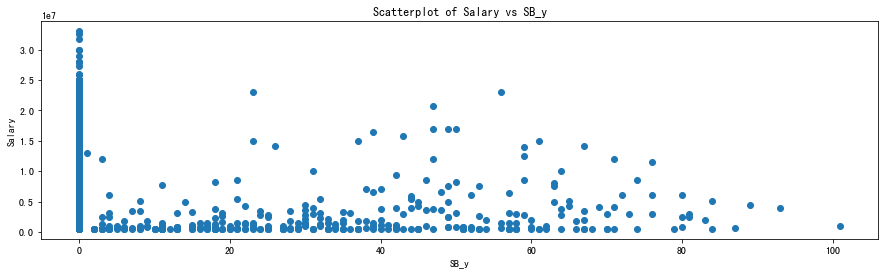

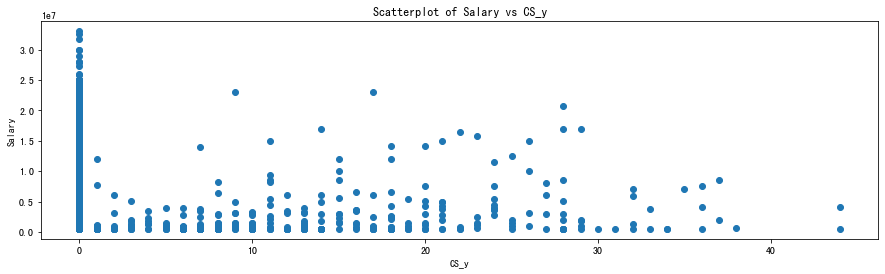

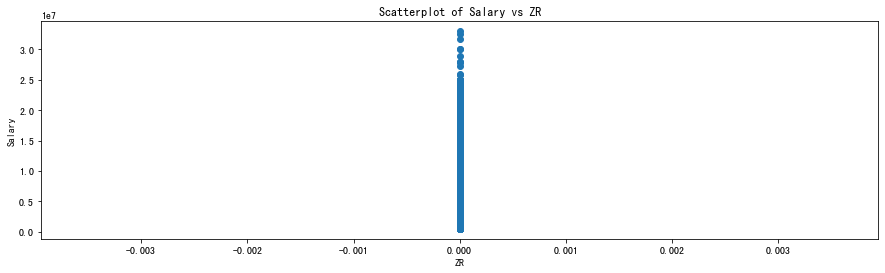

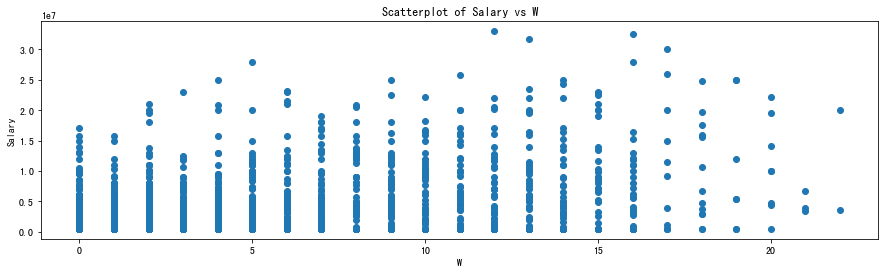

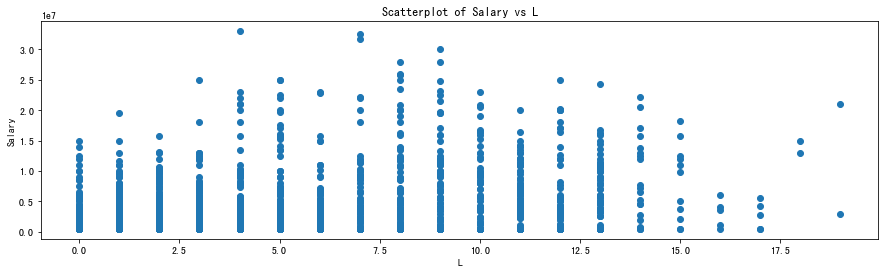

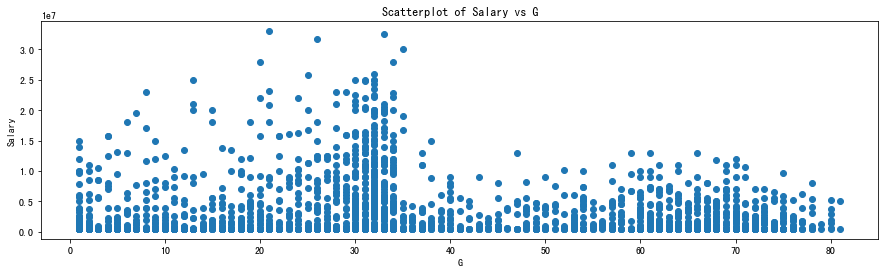

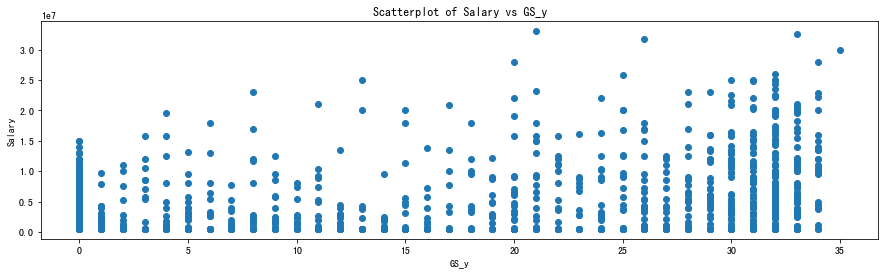

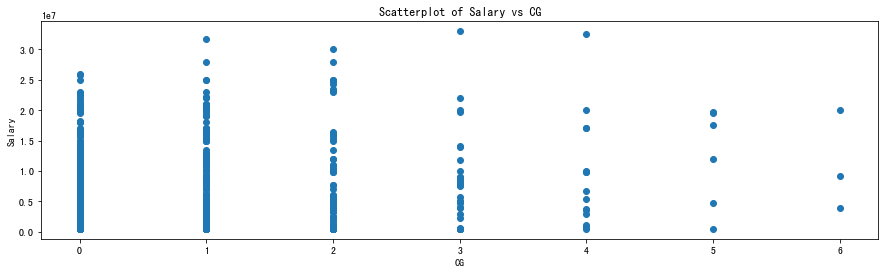

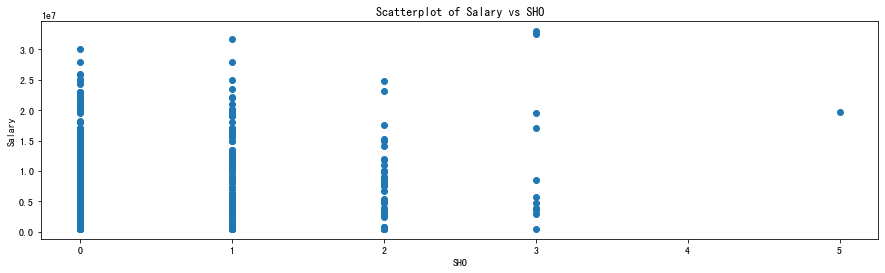

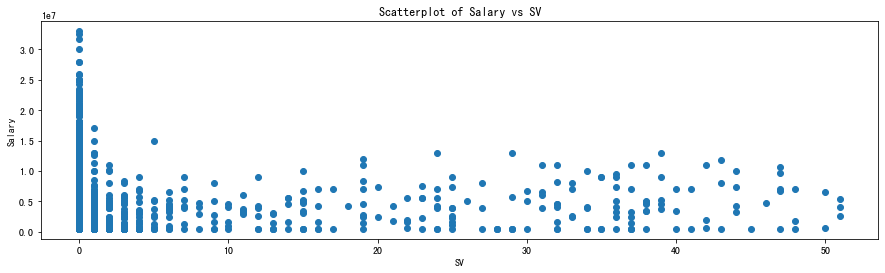

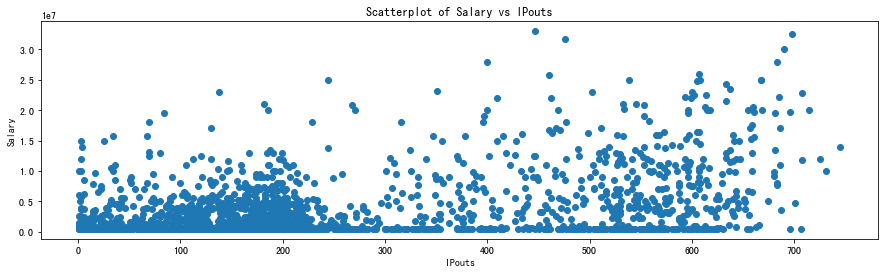

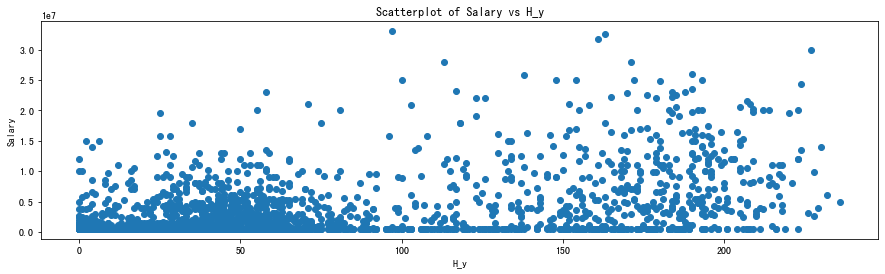

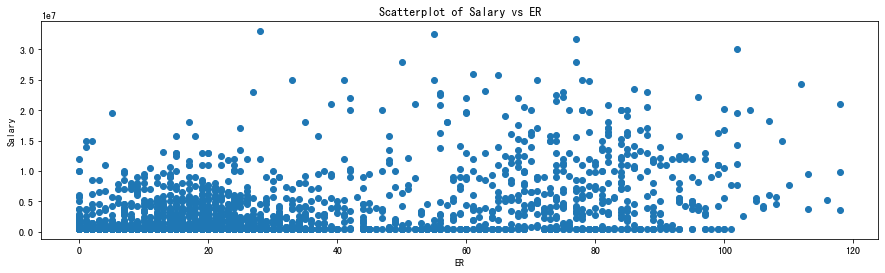

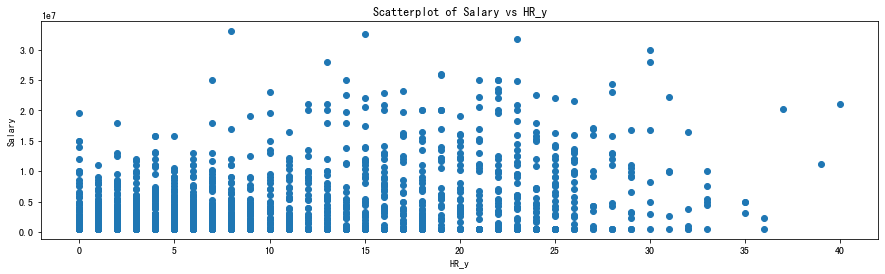

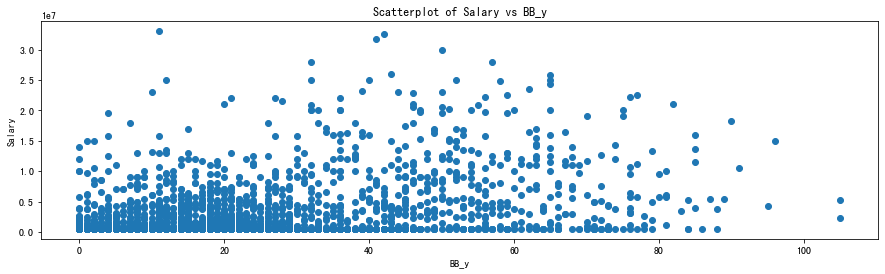

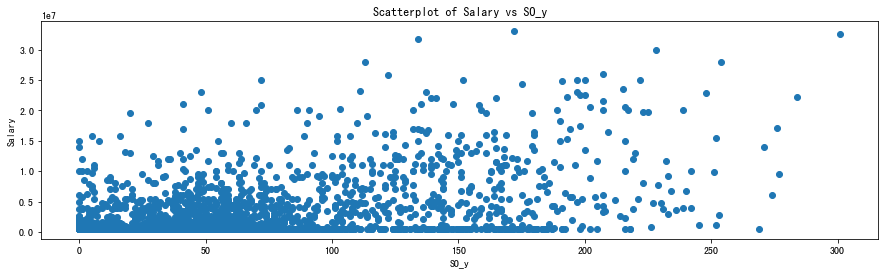

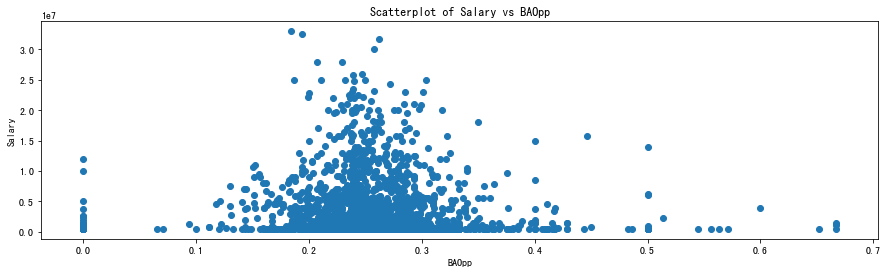

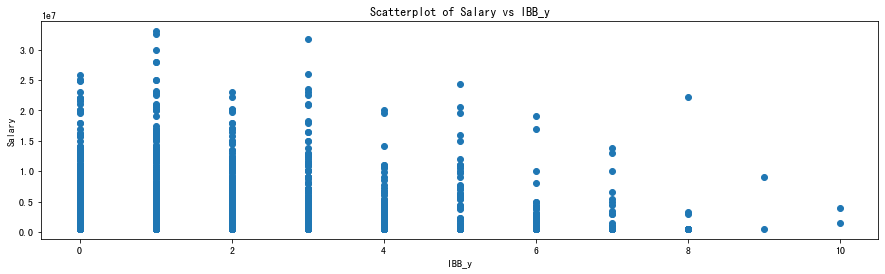

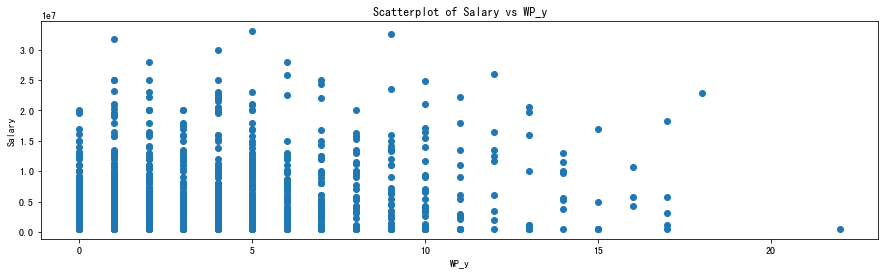

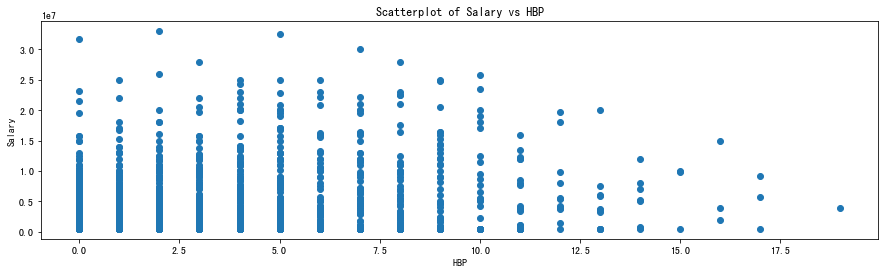

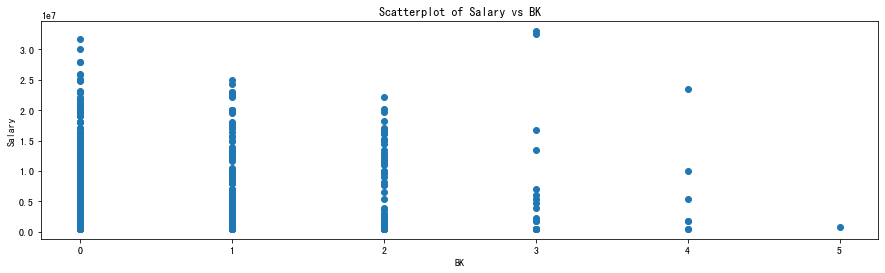

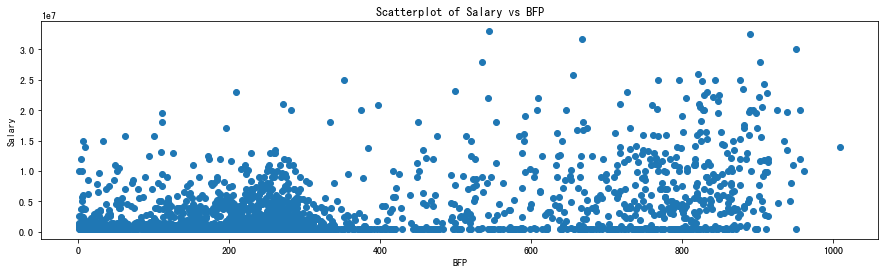

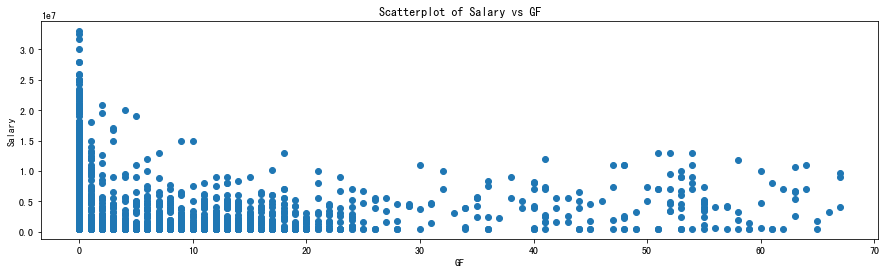

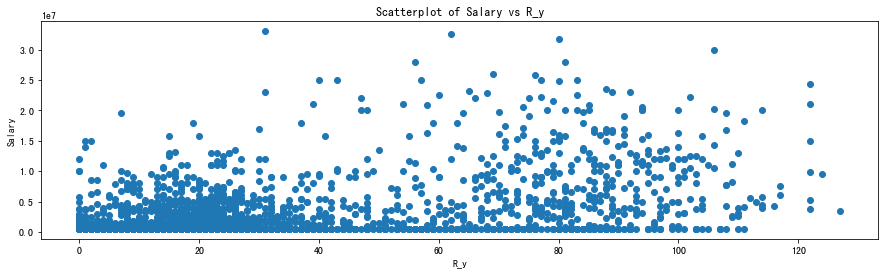

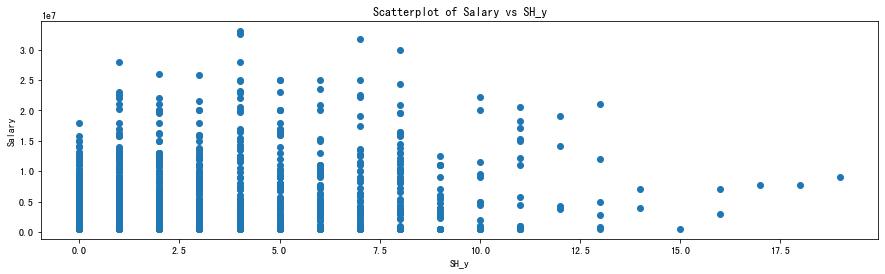

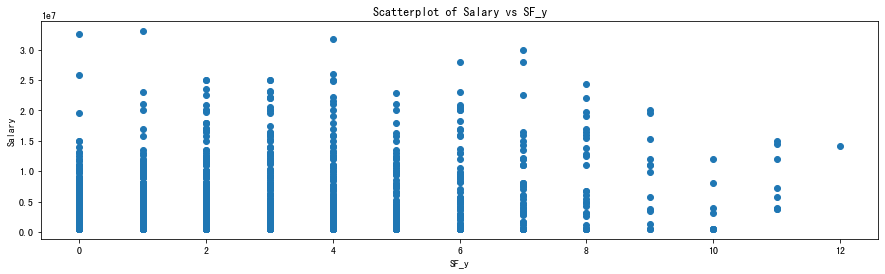

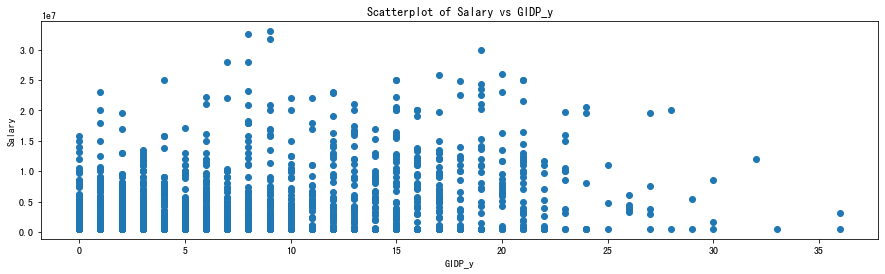

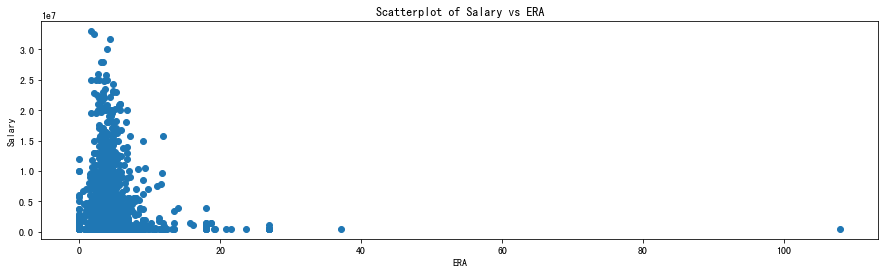

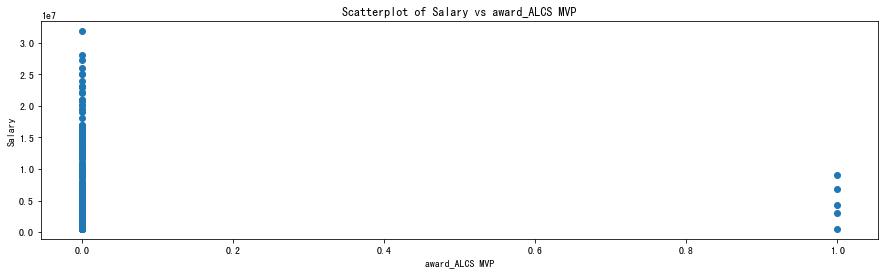

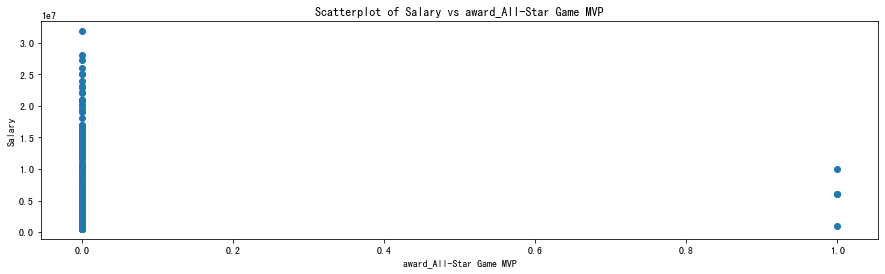

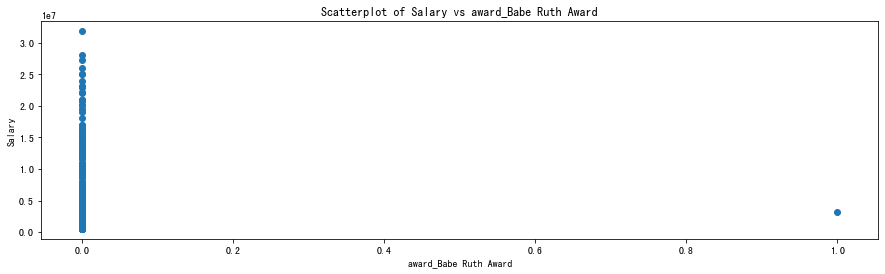

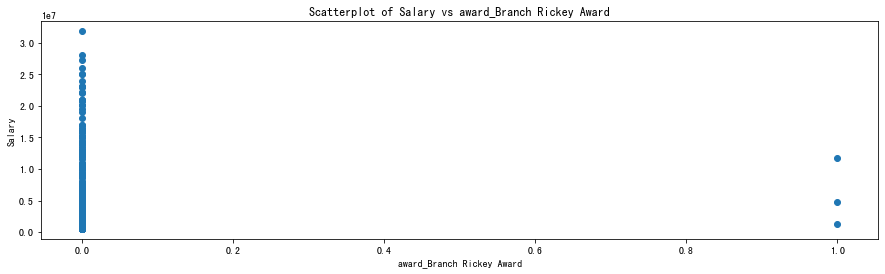

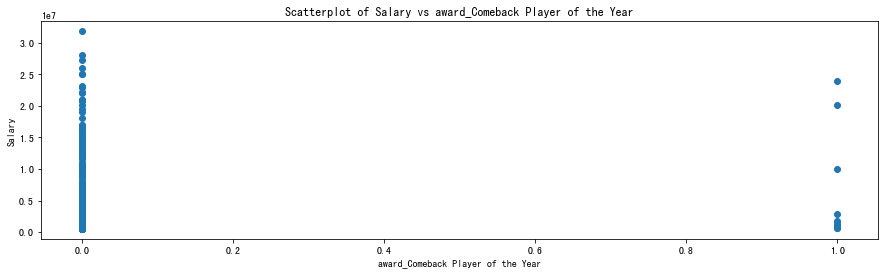

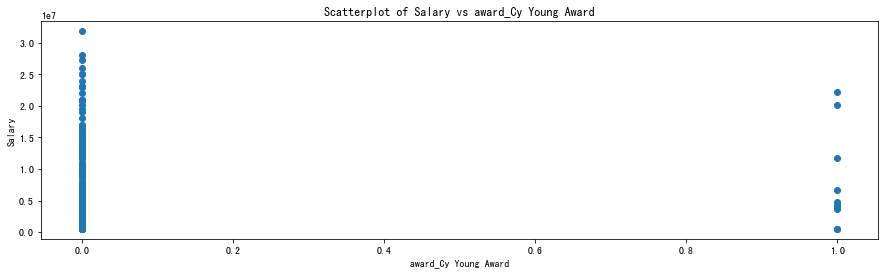

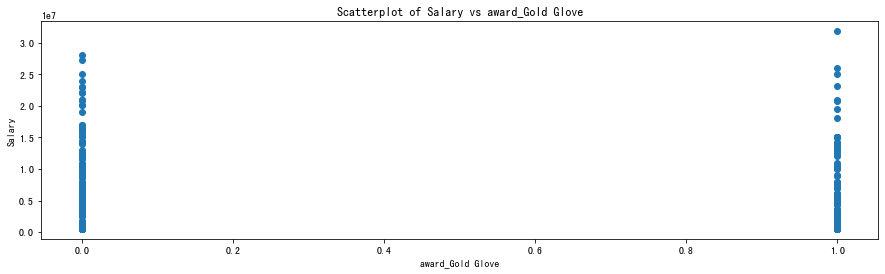

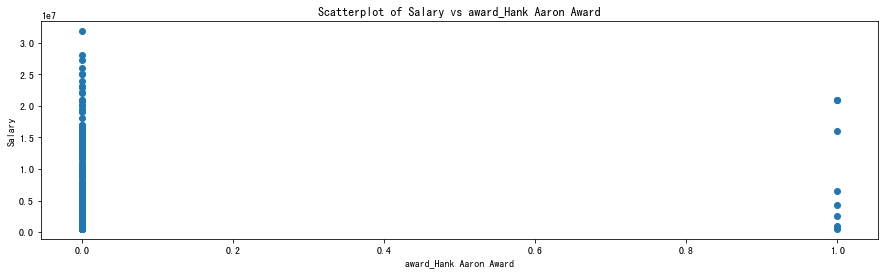

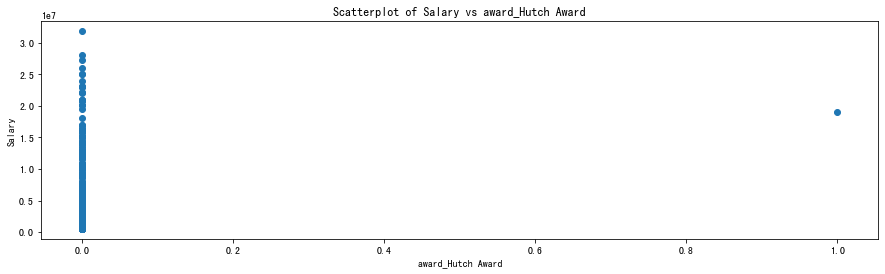

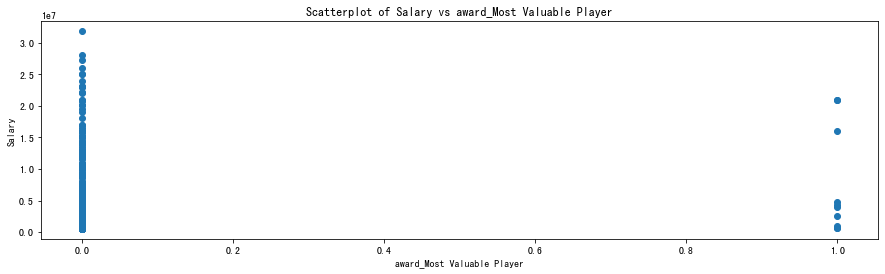

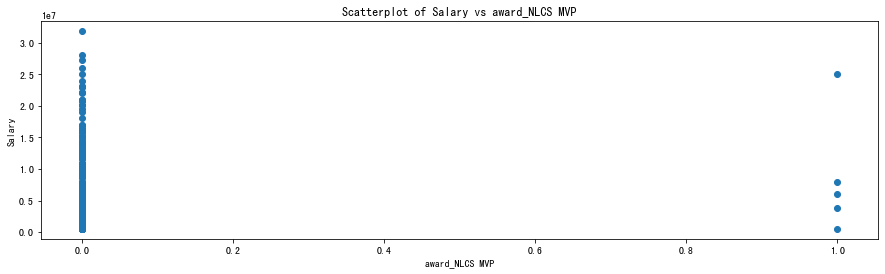

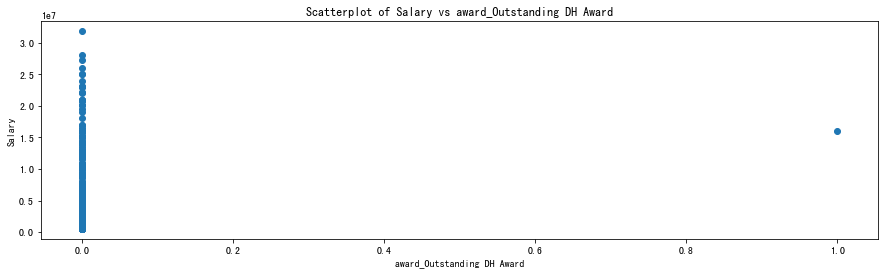

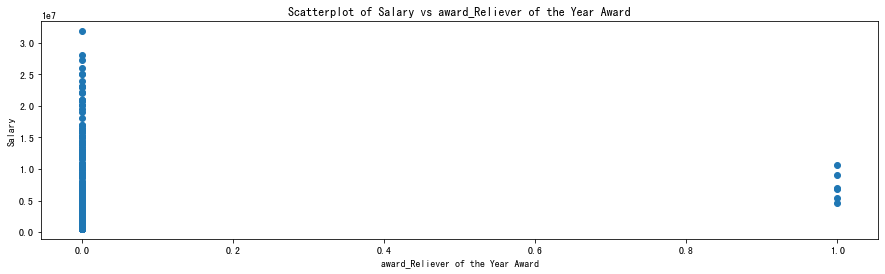

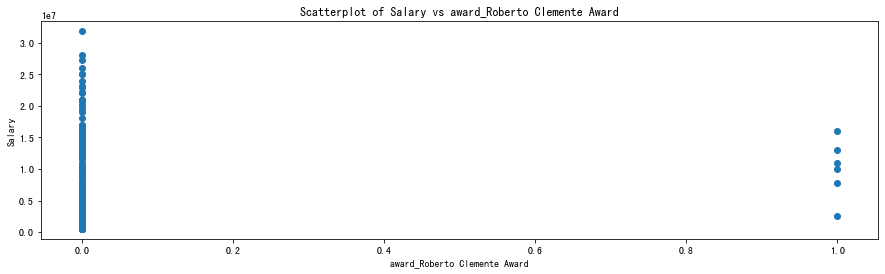

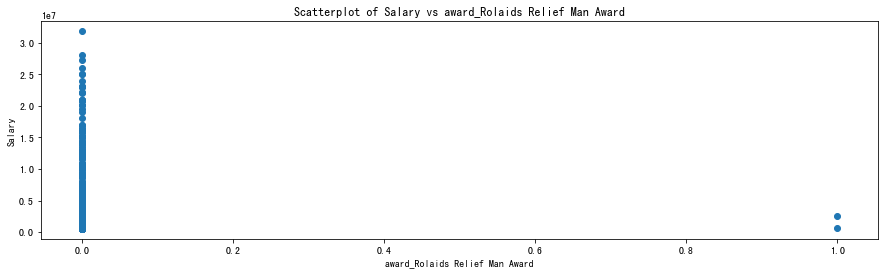

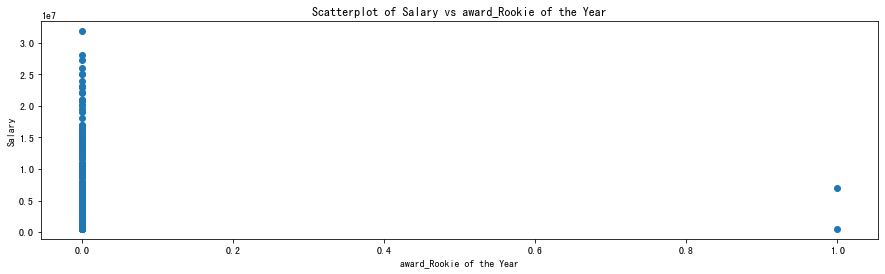

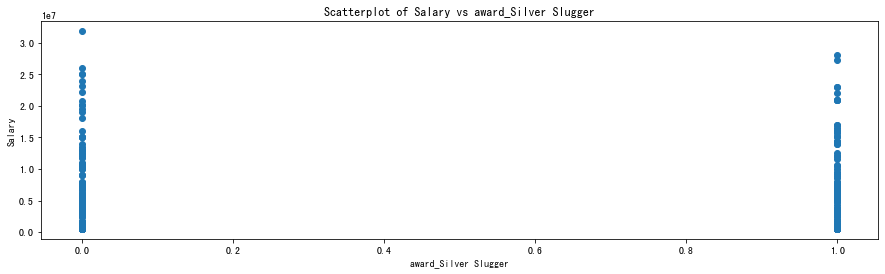

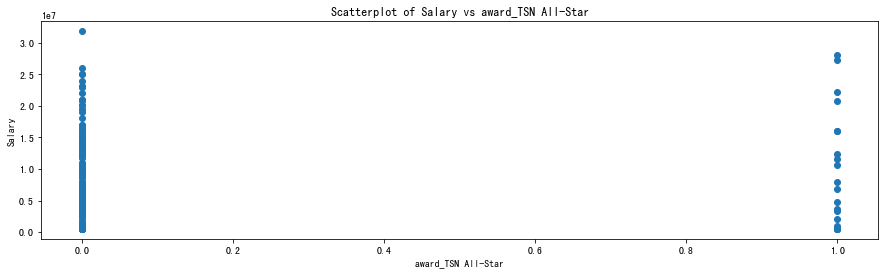

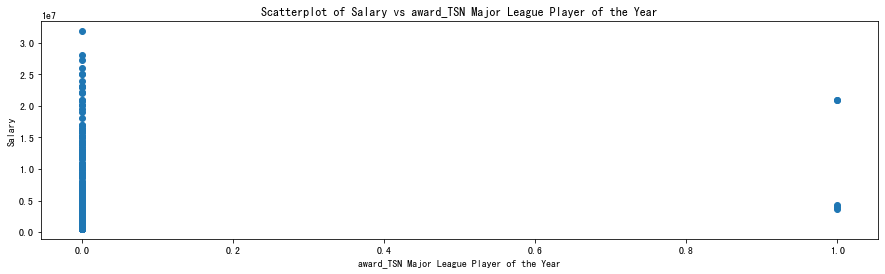

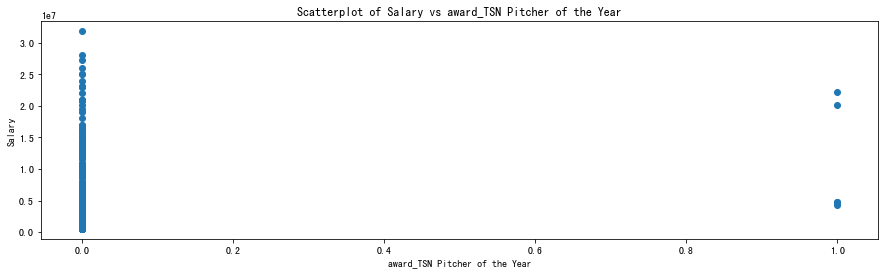

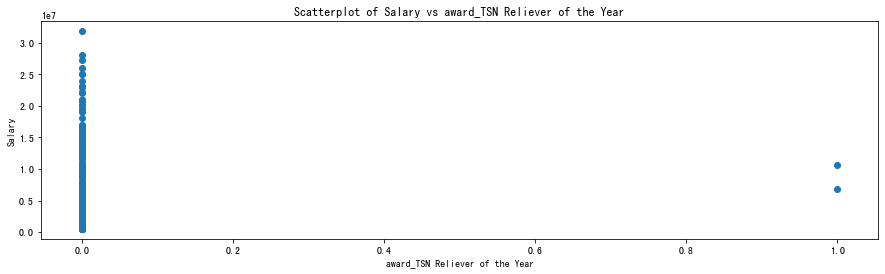

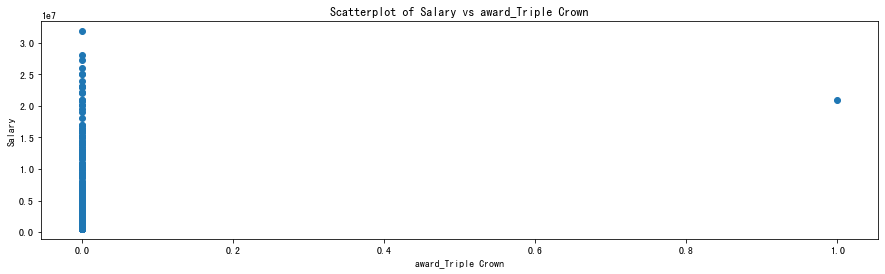

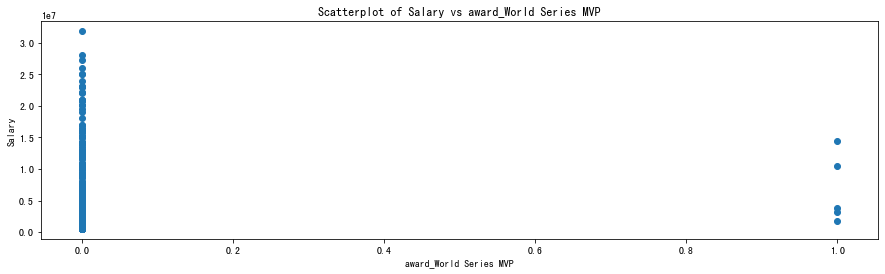

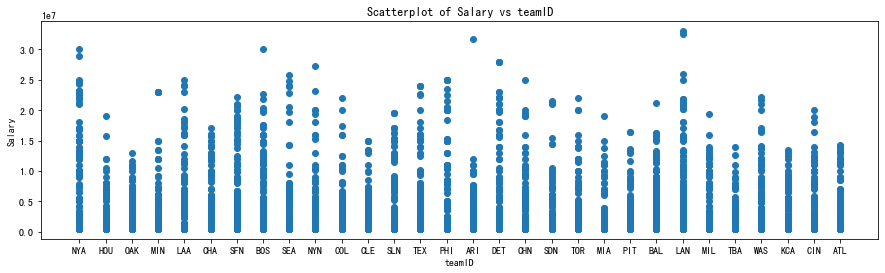

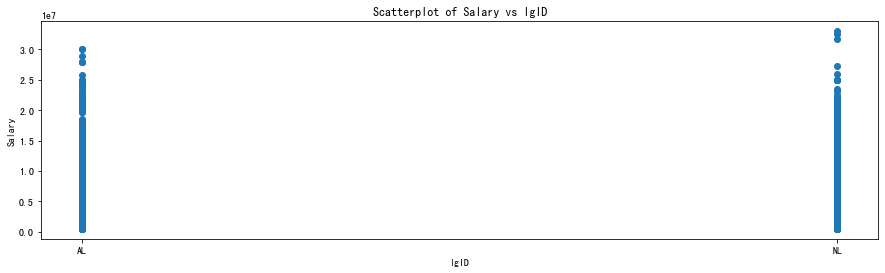

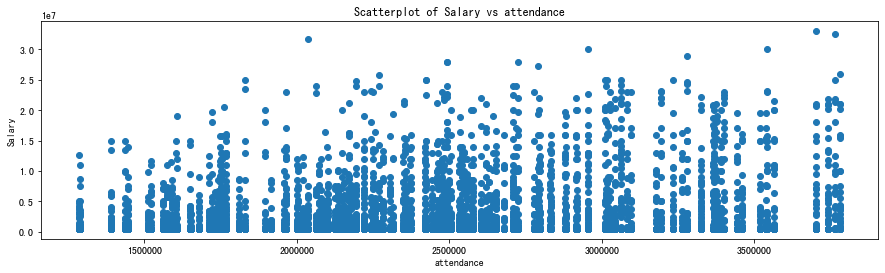

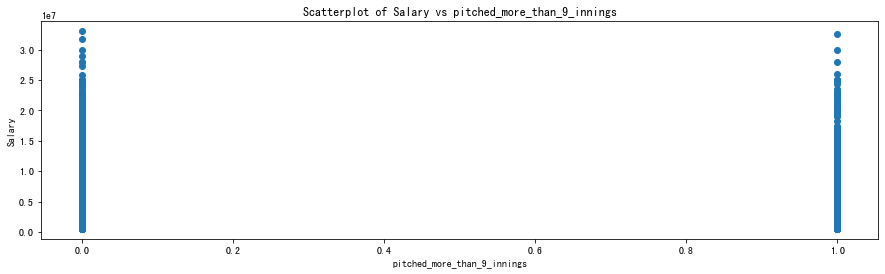

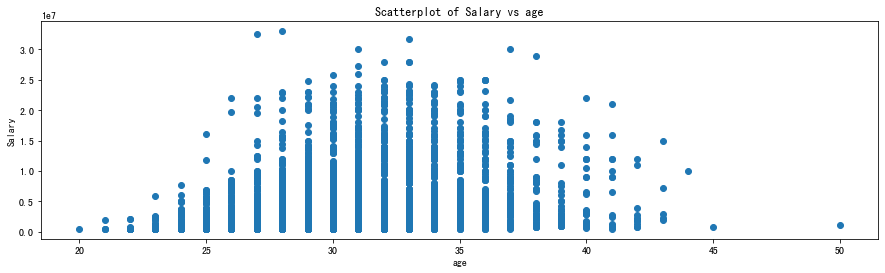

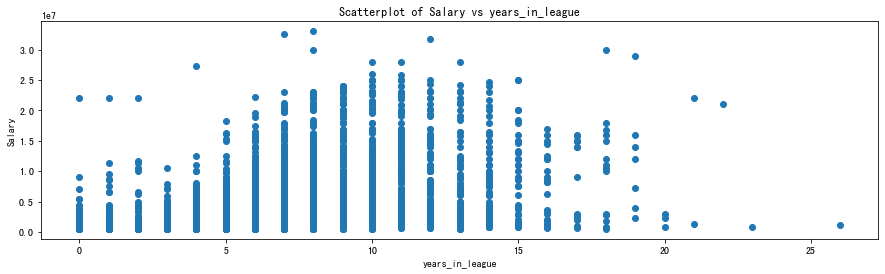

In [112]:
# plot scatterplots
for x_var in x_columns:
    fig = plt.figure(figsize = (15, 4))
    plt.scatter(final_df[x_var], final_df['salary'])
    plt.title(f'Scatterplot of Salary vs {x_var}')
    plt.xlabel(x_var)
    plt.ylabel('Salary')
    plt.show()

#### Data labeling

In [113]:
# use one-hot encoding to create dummy variables for each team
final_df = pd.get_dummies(final_df, columns=['teamID'], prefix='team')

In [114]:
# use one-hot encoding to create dummy variables for left/right handed for batting and pitching
final_df = pd.get_dummies(final_df, columns=['bats'], prefix='bats')
final_df = pd.get_dummies(final_df, columns=['throws'], prefix='throws')

In [115]:
# use label encoding to label league ID
# AL = 0, NL = 1
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

final_df['lgID'] = label_encoder.fit_transform(final_df['lgID'])

#### Handle missing values

In [116]:
# Filter columns that start with 'award' and fill null with 0
award_columns = [col for col in final_df.columns if col.startswith('award')]
final_df[award_columns] = final_df[award_columns].fillna(0)

In [117]:
# Filter columns of pitching stats and fill null with 0
final_df = final_df.fillna({
    'W':'0', 'L':'0', 'G':'0', 'GS_y':'0', 'CG':'0', 'GS_y':'0', 'SHO':'0', 'SV':'0', 'IPouts':'0',
    'H_y':'0', 'ER':'0', 'HR_y':'0', 'BB_y':'0', 'SO_y':'0', 'BAOpp':'0', 'IBB_y':'0', 'WP_y':'0',
    'HBP':'0', 'BK':'0', 'BFP':'0', 'GF':'0', 'R_y':'0', 'SH_y':'0', 'SF_y':'0', 'GIDP_y':'0', 'ERA':'0',
    'G_y':'0', 'GS_x':'0', 'InnOuts':'0', 'PO':'0', 'A':'0', 'E':'0', 'DP':'0', 'PB':'0', 'WP_x':'0', 'SB_y':'0',
    'CS_y':'0', 'ZR':'0'
})

In [118]:
# make sure there are no more missing values
pd.set_option('display.max_rows', None)
nulls = final_df.isnull().sum()
print(nulls)

weight                                       0
height                                       0
G_x                                          0
AB                                           0
R_x                                          0
H_x                                          0
2B                                           0
3B                                           0
HR_x                                         0
RBI                                          0
SB_x                                         0
CS_x                                         0
BB_x                                         0
SO_x                                         0
IBB_x                                        0
SH_x                                         0
SF_x                                         0
GIDP_x                                       0
G_y                                          0
GS_x                                         0
InnOuts                                      0
PO           

In [119]:
# display all columns
pd.set_option('display.max_columns', None)
final_df.head()

,weight,height,G_x,AB,R_x,H_x,2B,3B,HR_x,RBI,SB_x,CS_x,BB_x,SO_x,IBB_x,SH_x,SF_x,GIDP_x,G_y,GS_x,InnOuts,PO,A,E,DP,PB,WP_x,SB_y,CS_y,ZR,W,L,G,GS_y,CG,SHO,SV,IPouts,H_y,ER,HR_y,BB_y,SO_y,BAOpp,IBB_y,WP_y,HBP,BK,BFP,GF,R_y,SH_y,SF_y,GIDP_y,ERA,award_ALCS MVP,award_All-Star Game MVP,award_Babe Ruth Award,award_Branch Rickey Award,award_Comeback Player of the Year,award_Cy Young Award,award_Gold Glove,award_Hank Aaron Award,award_Hutch Award,award_Most Valuable Player,award_NLCS MVP,award_Outstanding DH Award,award_Reliever of the Year Award,award_Roberto Clemente Award,award_Rolaids Relief Man Award,award_Rookie of the Year,award_Silver Slugger,award_TSN All-Star,award_TSN Major League Player of the Year,award_TSN Pitcher of the Year,award_TSN Reliever of the Year,award_Triple Crown,award_World Series MVP,lgID,salary,attendance,pitched_more_than_9_innings,age,years_in_league,team_ARI,team_ATL,team_BAL,team_BOS,team_CHA,team_CHN,team_CIN,team_CLE,team_COL,team_DET,team_HOU,team_KCA,team_LAA,team_LAN,team_MIA,team_MIL,team_MIN,team_NYA,team_NYN,team_OAK,team_PHI,team_PIT,team_SDN,team_SEA,team_SFN,team_SLN,team_TBA,team_TEX,team_TOR,team_WAS,bats_B,bats_L,bats_R,throws_L,throws_R
0,215.0,75.0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,1,1,1,0.25,0,0,0,0,5,1,1,0,0,0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,500000.0,3542406.0,0,31.0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,235.0,74.0,37,7,0,1,0,0,0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,1.0,37,6,138,3,6,0,0,0,0,0,0,0,0,6,37,6,0,0,0,138,57,26,6,19,38,0.311,1,4,3,0,208,8,27,2,1,4,5.08696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,485000.0,1607733.0,1,27.0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,235.0,74.0,69,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,69,0,172,0,8,0,0,0,0,0,0,0,2,4,69,0,0,0,0,172,34,10,4,15,51,0.175,3,0,4,0,216,17,11,1,2,6,1.56977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,525900.0,2003628.0,1,29.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,235.0,74.0,62,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,62,0,143,2,4,0,0,0,0,0,0,0,2,2,62,0,0,0,0,143,45,22,11,19,45,0.251,3,4,1,0,205,17,23,3,3,1,4.15385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1087500.0,1768175.0,1,30.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,235.0,74.0,57,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,57,0,140,0,4,0,1,0,0,0,0,0,1,6,57,0,0,0,1,140,40,19,4,22,41,0.2375,2,1,1,1,198,15,20,0,1,7,3.66429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1250000.0,1963912.0,1,31.0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [120]:
# reset option
pd.reset_option('display.max_columns')

### Start building model

#### 1. Lasso Regression

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [122]:
# define X and y variables
X = final_df.drop(['salary'], axis=1)
y = final_df['salary']

# train test split using 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scaling the X values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating the lambda test values
alphas = np.logspace(-6, 0, 100)

# Creating 5 folds
k = 5
n = len(y_train)

# Shuffling the data
indices = np.arange(n)
np.random.shuffle(indices)

X_cv = X_train_scaled[indices]
y_cv = y_train.iloc[indices]

avg_rmse=[]

for alpha in alphas:
    rmse_list = []
    
    # Manual k-fold splitting
    for fold in range(k):
        # Calculating the size of each fold
        fold_size = n // k
        
        # Define the start and end indices of the test set
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train_cv, X_test_cv = X_cv[train_indices], X_cv[test_indices]
        y_train_cv, y_test_cv = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        lasso = Lasso(alpha=alpha)
        
        lasso.fit(X_train_cv, y_train_cv)
        
        y_pred_cv = lasso.predict(X_test_cv)
        rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

# Finding the best alpha
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha: {best_alpha}")

# fit lasso model with the best alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_test_scaled)

# get mse, rmse, and r2 of the model performance using OOS 
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Best alpha: 1.0
MSE: 12895104459223.4
RMSE: 3590975.4189110515
R-Squared: 0.49388791773995677


#### 2. Decision Tress

In [123]:
# perform train test split using 80:20 split
X = final_df.drop(['salary'], axis=1)
y = final_df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [124]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# build and fit a decision tree regressor model
regressor = DecisionTreeRegressor(max_depth=3) 
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

# get mse, rmse, and r2 of the model performance using OOS 
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MSE: 14088761023307.635
RMSE: 3753499.8365935273
R-Squared: 0.44703882000194406


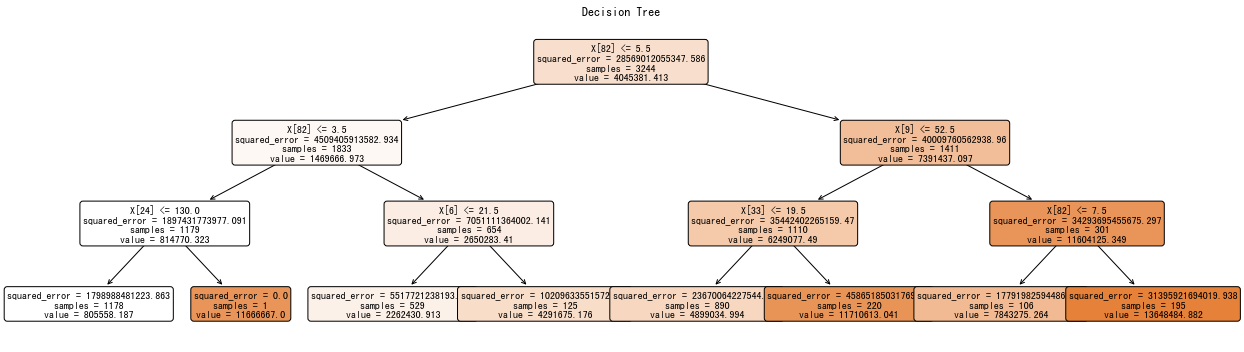

In [125]:
# Plot the decision tree
plt.figure(figsize=(35, 5))

# Subplot 1: The decision tree
plt.subplot(1, 2, 1)
plot_tree(regressor,filled=True,rounded=True,fontsize=10)
plt.title("Decision Tree")

# Display the plots
plt.tight_layout()
plt.show()

In [126]:
print("The following variables are in the plot:")
print("X[82]:", X.columns[82])
print("X[9]:", X.columns[9])
print("X[24]:", X.columns[24])
print("X[6]:", X.columns[6])
print("X[33]:", X.columns[33])

The following variables are in the plot:
X[82]: years_in_league
X[9]: RBI
X[24]: DP
X[6]: 2B
X[33]: GS_y


#### 3. Random Forest

In [127]:
# define x and y variables
X = final_df.drop(['salary'], axis=1)
y = final_df['salary']

# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Scaling the X values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [128]:
from sklearn.ensemble import RandomForestRegressor

# fit a random forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled, y_train)
prediction = rf_model.predict(X_test_scaled)

# get mse, rmse, and r2 of the model performance using OOS 
mse = mean_squared_error(y_test, prediction)
rmse = sqrt(mean_squared_error(y_test, prediction))
r2 = r2_score(y_test, prediction)

print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MSE: 9505924639212.17
RMSE: 3083167.9550767536
R-Squared: 0.6269077673490622


In [135]:
# Access feature importances
importances = rf_model.feature_importances_

for i, importance in enumerate(importances):
    print(f"Feature {i+1}: {X.columns[i]}: Importance = {importance}")

Feature 1: weight: Importance = 0.01849295537478544
Feature 2: height: Importance = 0.01944063939208108
Feature 3: G_x: Importance = 0.019881370522855036
Feature 4: AB: Importance = 0.024484872953221316
Feature 5: R_x: Importance = 0.03657943496132084
Feature 6: H_x: Importance = 0.010270613196669873
Feature 7: 2B: Importance = 0.0111060652022029
Feature 8: 3B: Importance = 0.004487569331941875
Feature 9: HR_x: Importance = 0.010887181267558443
Feature 10: RBI: Importance = 0.05265860616179428
Feature 11: SB_x: Importance = 0.009046637359316398
Feature 12: CS_x: Importance = 0.0026306443498018387
Feature 13: BB_x: Importance = 0.01051062467365561
Feature 14: SO_x: Importance = 0.008801600273364655
Feature 15: IBB_x: Importance = 0.010832841816778412
Feature 16: SH_x: Importance = 0.009499995463226
Feature 17: SF_x: Importance = 0.00669811131349482
Feature 18: GIDP_x: Importance = 0.006376382802367373
Feature 19: G_y: Importance = 0.007593192839302659
Feature 20: GS_x: Importance = 0.01

We know that lower MSE and RMSE, and a higher R-squared indicate better model. Comparing all model, including lasso, decision tree, and random forest, we can conclude that the random forest model fits the Out of Sample data the best.